In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [9]:
U = 19.05

In [10]:
a = "a"
b = "b"
c = "c"
d = "d"
e = "e"
f = "f"
g = "g"
h = "h"
i = "i"
j = "j"
k = "k"
l = "l"
m = "m"
n = "n"
o = "o"
p = "p"
q = "q"
r = "r"
s = "s"
t = "t"
u = "u"
v = "v"
w = "w"
x = "x"
y = "y"
z = "z"

In [11]:
class KleState:
    def __init__(self):
        self.x = 0.0
        self.y = 0.0
        
        # Properties that reset after each key unless specified again
        self.width = 1.0
        self.height = 1.0
        self.x2 = 0.0
        self.y2 = 0.0
        self.width2 = 1.0  # Defaults to primary key's width
        self.height2 = 1.0 # Defaults to primary key's height
        self.rotation_x = 0.0 # Rotation origin X
        self.rotation_y = 0.0 # Rotation origin Y
        self.rotation_angle = 0.0 # Rotation angle in degrees
        self.decal = False    # 'd' property
        self.stepped = False  # 'l' property (legend-only, often for stepped keys)
        self.nub = False      # 'n' property (no-op/homing nub)

        # Sticky properties (persist until changed)
        self.color = "#cccccc"  # Default keycap color ('c' property)
        self.textColor = "#000000" # Default text color ('t' property, can be complex)
        self.textSize = []    # 'f' property family (font sizes for legends)
        self.textAlign = []   # 'a' property (alignments for legends)
        self.profile = ""     # 'p' property (keycap profile)
        self.ghost = False    # 'g' property (semi-transparent key)
        
        # Switch related properties (sticky, not used in this visualizer)
        self.sm = "" # switch mount
        self.sb = "" # switch brand
        self.st = "" # switch type

    def reset_non_sticky_properties(self):
        """Resets properties that don't carry over after a key is defined."""
        self.width = 1.0
        self.height = 1.0
        self.x2 = 0.0
        self.y2 = 0.0
        self.width2 = 1.0  # Should reflect the new default width (1.0)
        self.height2 = 1.0 # Should reflect the new default height (1.0)
        self.decal = False
        self.stepped = False
        self.nub = False
        self.rotation_angle = 0.0
        # Rotation origin (rx, ry) also effectively resets because if not specified for the next key,
        # it defaults to that key's top-left.
        # self.rotation_x = self.x # This would be current key's top-left if needed for default
        # self.rotation_y = self.y

    def update_from_metadata(self, metadata_obj):
        """Updates state from a KLE metadata object."""
        # Sticky properties
        if 'c' in metadata_obj: self.color = metadata_obj['c']
        if 't' in metadata_obj: self.textColor = metadata_obj['t'] # Note: can be complex (multi-color string)
        if 'g' in metadata_obj: self.ghost = metadata_obj['g']
        if 'p' in metadata_obj: self.profile = metadata_obj['p']
        if 'a' in metadata_obj: self.textAlign = metadata_obj['a'] # Store raw, renderer needs to handle
        if 'f' in metadata_obj: self.textSize = metadata_obj['f'] # Store raw

        # Non-sticky properties (or properties that directly set values for the current key)
        # Order matters: w/h should be set before w2/h2 if w2/h2 depend on them by default
        if 'w' in metadata_obj: self.width = metadata_obj['w']; self.width2 = self.width
        else: self.width2 = self.width # ensure width2 tracks width if w not set but w2 relies on it

        if 'h' in metadata_obj: self.height = metadata_obj['h']; self.height2 = self.height
        else: self.height2 = self.height # ensure height2 tracks height

        if 'x2' in metadata_obj: self.x2 = metadata_obj['x2']
        if 'y2' in metadata_obj: self.y2 = metadata_obj['y2']
        if 'w2' in metadata_obj: self.width2 = metadata_obj['w2'] # Override default if specified
        if 'h2' in metadata_obj: self.height2 = metadata_obj['h2'] # Override default if specified
        
        if 'l' in metadata_obj: self.stepped = metadata_obj['l']
        if 'n' in metadata_obj: self.nub = metadata_obj['n']
        if 'd' in metadata_obj: self.decal = metadata_obj['d']
        
        # Rotation: 'r' is angle, 'rx'/'ry' set origin and also move the current x/y cursor
        if 'r' in metadata_obj: self.rotation_angle = metadata_obj['r']
        if 'rx' in metadata_obj: self.rotation_x = metadata_obj['rx']; self.x = self.rotation_x
        if 'ry' in metadata_obj: self.rotation_y = metadata_obj['ry']; self.y = self.rotation_y


def parse_kle_layout_spec_compliant(kle_data_serial):
    all_keys_info = []
    current_state = KleState()
    scan_code_counter = 1

    # Handle keyboard-level metadata if present (first item is dict, not list)
    if kle_data_serial and isinstance(kle_data_serial[0], dict):
        keyboard_metadata = kle_data_serial.pop(0) # Remove and process
        # Example: current_state.update_from_metadata(keyboard_metadata.get("meta", {}))
        # This example doesn't fully implement keyboard meta, but shows where it would go.
        pass # For now, assuming it's not used or handled by this basic parser.

    for i, row_items_serial in enumerate(kle_data_serial):
        # Default row progression: y increments by 1, x resets to 0
        # (unless this is the very first action, y starts at 0 implicitly)
        if i > 0 or (i == 0 and current_state.y > 0): # Avoid y increment if it's truly row 0 at y=0
             # This logic ensures y increments if it's a new row after some keys have been placed.
             # If previous row was empty but moved y, this is fine.
             # If it's the actual first row (i=0) and y is still 0 (no prior global y offset), don't increment yet.
            current_state.y += 1.0 
        current_state.x = 0.0
        
        # Backup sticky properties before applying row-level or key-specific changes
        # that might temporarily alter them for non-sticky interpretation.
        # No, this is not needed, state object itself manages sticky vs non-sticky.

        elements_in_row = list(row_items_serial) # Make a mutable copy

        # Handle row-level metadata (if the first item in the row is a dict)
        if elements_in_row and isinstance(elements_in_row[0], dict):
            row_metadata = elements_in_row.pop(0)
            
            # Relative x/y adjustments for the start of this row
            current_state.x += row_metadata.pop('x', 0.0)
            current_state.y += row_metadata.pop('y', 0.0)
            
            # Update other properties from row metadata for the first key or as new defaults
            current_state.update_from_metadata(row_metadata)

        for item_in_row in elements_in_row:
            if isinstance(item_in_row, dict):
                # Metadata for subsequent key(s)
                # Relative x/y adjustments
                current_state.x += item_in_row.pop('x', 0.0)
                current_state.y += item_in_row.pop('y', 0.0)
                
                current_state.update_from_metadata(item_in_row)
            else:
                # It's a key (string legend)
                key_legend_text = str(item_in_row)
                
                # Create key data using current state
                key_info = {
                    'scan_code': scan_code_counter,
                    'label': key_legend_text, # Renderer will need to handle multi-legend text from \n
                    'x': current_state.x,
                    'y': current_state.y,
                    'width': current_state.width,
                    'height': current_state.height,
                    'color': current_state.color,
                    'textColor': current_state.textColor, # Raw, could be complex string
                    'ghost': current_state.ghost,
                    'stepped': current_state.stepped,
                    'nub': current_state.nub,
                    'decal': current_state.decal,
                    'rotation_angle': current_state.rotation_angle,
                    'rotation_x': current_state.rotation_x, # Origin for rotation
                    'rotation_y': current_state.rotation_y, # Origin for rotation
                    'x2': current_state.x2, 'y2': current_state.y2, # For secondary rect of key
                    'width2': current_state.width2, 'height2': current_state.height2,
                    'profile': current_state.profile,
                    'textAlign': current_state.textAlign, # Raw array
                    'textSize': current_state.textSize # Raw array
                }
                all_keys_info.append(key_info)
                scan_code_counter += 1

                # Advance x-cursor by the width of the key just placed
                current_state.x += current_state.width
                
                # Reset non-sticky properties for the next key
                current_state.reset_non_sticky_properties()
                
    # Create mappings for the drawing function (can be adapted as needed)
    logical_map = {k['scan_code']: k['label'] for k in all_keys_info}
    color_map = {k['scan_code']: k['color'] for k in all_keys_info}
    
    return all_keys_info, logical_map, color_map


def draw_keyboard(physical_layout_keys, logical_map_labels, color_map_fill, title="Keyboard Layout"):
    # (This drawing function is kept similar to your original for compatibility,
    # but it doesn't use many of the newly parsed properties like rotation, textColor, etc.
    # A more advanced renderer would be needed for full KLE fidelity.)
    fig, ax = plt.subplots(figsize=(20, 10))

    if not physical_layout_keys:
        ax.text(0.5, 0.5, "No layout data to draw.", ha='center', va='center')
        ax.axis('off')
        plt.show()
        return

    min_x_coord = min(k['x'] for k in physical_layout_keys)
    max_x_coord = max(k['x'] + k['width'] for k in physical_layout_keys)
    min_y_coord = min(k['y'] for k in physical_layout_keys)
    max_y_coord = max(k['y'] + k['height'] for k in physical_layout_keys)

    for key_props in physical_layout_keys:
        x_pos, y_pos = key_props['x'], key_props['y']
        key_w, key_h = key_props['width'], key_props['height']
        s_code = key_props['scan_code']
        
        key_fill_color = color_map_fill.get(s_code, '#dddddd')

        # Basic rectangle (no rotation or complex shapes handled here yet)
        rect = patches.Rectangle(
            (x_pos, y_pos), key_w, key_h,
            edgecolor='black',
            facecolor=key_fill_color,
            linewidth=1,
            alpha=0.5 if key_props.get('ghost', False) else 1.0 # Basic ghosting
        )
        ax.add_patch(rect)
        
        # Text label (main legend part, centered)
        label_text_parts = logical_map_labels.get(s_code, f"SC:{s_code}").split('\n')
        main_label = label_text_parts[0] # Display primary legend
        # More advanced text rendering would loop through label_text_parts with positions/colors

        font_size_main = 15
        if key_w < 0.8 or key_h < 0.8: font_size_main = 11
        if len(label_text_parts) > 1: font_size_main = min(font_size_main, 14)
        
        # For multi-line, adjust y position slightly to center the block
        num_lines = len(label_text_parts)
        line_height_approx = font_size_main / 36 * fig.dpi * 0.3 # Very rough estimate
        total_text_height_approx = num_lines * line_height_approx
        text_y_center = y_pos + key_h / 2 # - total_text_height_approx / 2 + line_height_approx /2

        ax.text(
            x_pos + key_w / 2, text_y_center, # Use adjusted y for multi-line
            '\n'.join(label_text_parts), # Render all lines if multi-line
            ha='center', 
            va='center', 
            fontsize=font_size_main, 
            color='black', # Default text color
            fontweight='bold', # <--- Added this line
            wrap=True
        )
        
        # Scan code in corner
        ax.text(
            x_pos + 0.05 * key_w, y_pos + 0.05 * key_h,
            str(s_code),
            ha='left', va='bottom', fontsize=5, alpha=0.7, color='black'
        )

    ax.set_xlim(min_x_coord - 0.5, max_x_coord + 0.5)
    ax.set_ylim(min_y_coord - 0.5, max_y_coord + 0.5)
    ax.set_aspect('equal')
    ax.invert_yaxis()  # KLE y increases downwards, Matplotlib y increases upwards
    ax.axis('off')
    plt.title(title, fontsize=20)
    plt.tight_layout()
    plt.show()

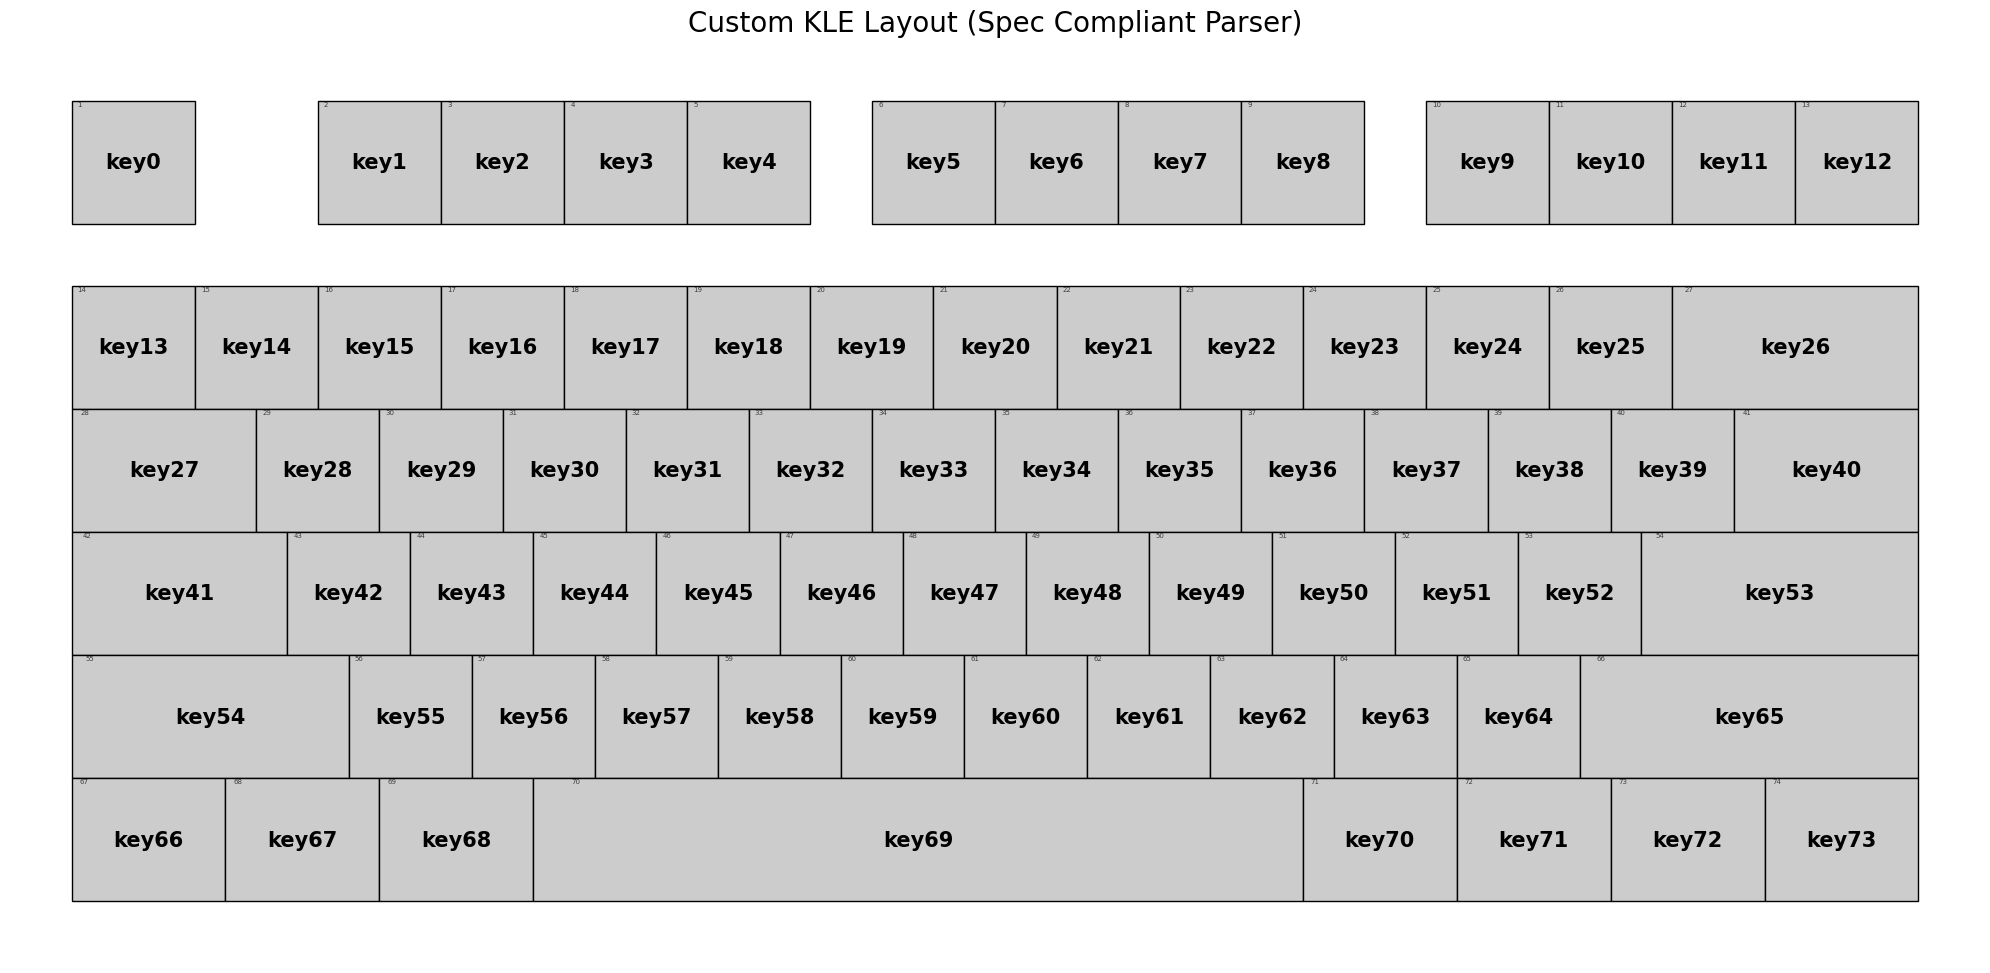

In [12]:
# KLE data (ensure it's correctly formatted Python)
kle_data = [
["key0",{x:1},"key1","key2","key3","key4",{x:0.5},"key5","key6","key7","key8",{x:0.5},"key9","key10","key11","key12"],
[{y:0.5},"key13","key14","key15","key16","key17","key18","key19","key20","key21","key22","key23","key24","key25",{w:2},"key26"],
[{w:1.5},"key27","key28","key29","key30","key31","key32","key33","key34","key35","key36","key37","key38","key39",{w:1.5},"key40"],
[{w:1.75},"key41","key42","key43","key44","key45","key46","key47","key48","key49","key50","key51","key52",{w:2.25},"key53"],
[{w:2.25},"key54","key55","key56","key57","key58","key59","key60","key61","key62","key63","key64",{w:2.75},"key65"],
[{w:1.25},"key66",{w:1.25},"key67",{w:1.25},"key68",{a:7,w:6.25},"key69",{a:4,w:1.25},"key70",{w:1.25},"key71",{w:1.25},"key72",{w:1.25},"key73"]
]





# Parse the layout using the spec-compliant parser
physical_layout, logical_layout, color_layout = parse_kle_layout_spec_compliant(kle_data)

# Modify colors (example)
# if 1 in color_layout: color_layout[1] = '#FF0000' 
# if 5 in color_layout: color_layout[32] = '#00FF00' 

# Draw the keyboard
draw_keyboard(physical_layout, logical_layout, color_layout, "Custom KLE Layout (Spec Compliant Parser)")

In [13]:
def map_layout_to_kle(kle_layout_data, logical_layout_list):
    """
    Maps a linear list of key labels (logical layout) to a KLE layout definition.

    Args:
        kle_layout_data:  The KLE layout data structure (list of lists/dicts).
        logical_layout_list: A list of strings, representing the key labels in the
                             desired layout order.

    Returns:
        A modified KLE layout data structure with the labels from logical_layout_list
        applied to the keys defined in kle_layout_data.  Returns a *new* data structure,
        does not modify the input kle_layout_data in place.
        Returns None on error.
    """
    new_kle_layout = [] # Create a copy to modify
    key_index = 0 # Track which label we are taking from logical_layout_list

    def process_kle_item(item):
      """Helper to process one item, recurses for lists."""
      nonlocal key_index # Allow modification of the outer scope variable
      if isinstance(item, list):
        new_list = []
        for sub_item in item:
          new_list.append(process_kle_item(sub_item)) # Recursive call
        return new_list
      elif isinstance(item, dict):
        return item # Dictionaries are copied as is.
      elif isinstance(item, str):
        # String: this is where we put the logical layout label
        if key_index < len(logical_layout_list):
          new_label = logical_layout_list[key_index]
          key_index += 1
          return new_label # replace string with the label
        else:
          return "" # Or some placeholder, or you could raise an exception
      else:
        return item #numbers etc
    
    new_kle_layout = process_kle_item(kle_layout_data)
    return new_kle_layout

In [14]:
layout_data = {
    "FINGER": [
        "u", "u", "u", "u", "u", "u", "u", "u", "u", "u", "u", "u", "u", "lp", "lp", "lr", "lm",
        "li", "li", "ri", "ri", "rm", "rr", "rp", "rp", "rp", "rp", "lp", "lp", "lr", "lm", "li", "li", "ri", "ri", "rm", "rr", "rp", "rp", "rp", "rp",
        "lp", "LP", "LR", "LM", "LI", "li", "ri", "RI", "RM", "RR", "RP", "rp", "rp", "lp", "lp", "lr", "lm", "li", "li", "ri", "ri", "rm", "rr", "rp", "rp",
        "u", "u", "u", "LTRT", "u", "u", "u", "u"
        ],
    "DISTANCE": layout_distance,
    "QWERTY": [
        "ESC", "F1", "F2", "F3", "F4", "F5", "F6", "F7", "F8", "F9", "F10", "F11", "F12",
        "`", "1", "2", "3", "4", "5", "6", "7", "8", "9", "0", "-", "=", "BACKSPACE",
        "TAB", "Q", "W", "E", "R", "T", "Y", "U", "I", "O", "P", "[", "]", "\\",
        "CAPS LOCK", "A", "S", "D", "F", "G", "H", "J", "K", "L", ";", "'", "ENTER",
        "SHIFT", "Z", "X", "C", "V", "B", "N", "M", ",", ".", "/", "SHIFT",
        "CTRL", "WIN", "ALT", "SPACE", "ALT", "WIN", "MENU", "CTRL"
    ],
    "MINIMAK":  [
        "ESC", "F1", "F2", "F3", "F4", "F5", "F6", "F7", "F8", "F9", "F10", "F11", "F12",
        "`", "1", "2", "3", "4", "5", "6", "7", "8", "9", "0", "-", "=", "BACKSPACE",
        "TAB", "Q", "W", "D", "F", "K", "Y", "U", "I", "L", ";", "[", "]", "\\",
        "CAPS LOCK", "A", "S", "T", "R", "G", "H", "N", "E", "O", "P", "'", "ENTER",
        "SHIFT", "Z", "X", "C", "V", "B", "J", "M", ",", ".", "/", "SHIFT",
        "CTRL", "WIN", "ALT", "SPACE", "ALT", "WIN", "MENU", "CTRL"
    ],
    "DVORAK": [
        "ESC", "F1", "F2", "F3", "F4", "F5", "F6", "F7", "F8", "F9", "F10", "F11", "F12",
        "`", "1", "2", "3", "4", "5", "6", "7", "8", "9", "0", "[", "]", "BACKSPACE",
        "TAB", "'", ",", ".", "P", "Y", "F", "G", "C", "R", "L", "/", "=", "\\",
        "CAPS LOCK", "A", "O", "E", "U", "I", "D", "H", "T", "N", "S", "-", "ENTER",
        "SHIFT", ";", "Q", "J", "K", "X", "B", "M", "W", "V", "Z", "SHIFT",
        "CTRL", "WIN", "ALT", "SPACE", "ALT", "WIN", "MENU", "CTRL"
    ],
    "WORKMAN": [
        "ESC", "F1", "F2", "F3", "F4", "F5", "F6", "F7", "F8", "F9", "F10", "F11", "F12",
        "`", "1", "2", "3", "4", "5", "6", "7", "8", "9", "0", "-", "=", "BACKSPACE",
        "TAB", "Q", "D", "R", "W", "B", "J", "F", "U", "P", ";", "[", "]", "\\",
        "BACKSPACE", "A", "S", "H", "T", "G", "Y", "N", "E", "O", "I", "'", "ENTER",
        "SHIFT", "Z", "X", "M", "C", "V", "K", "L", ",", ".", "/", "SHIFT",
        "CTRL", "WIN", "ALT", "SPACE", "ALT", "WIN", "MENU", "CTRL"
    ],
    "NORMAN":  [
        "ESC", "F1", "F2", "F3", "F4", "F5", "F6", "F7", "F8", "F9", "F10", "F11", "F12",
        "`", "1", "2", "3", "4", "5", "6", "7", "8", "9", "0", "-", "=", "BACKSPACE",
        "TAB", "Q", "W", "D", "F", "K", "J", "U", "R", "L", ";", "[", "]", "\\",
        "CAPS LOCK", "A", "S", "E", "T", "G", "Y", "N", "I", "O", "H", "'", "ENTER",
        "SHIFT", "Z", "X", "C", "V", "B", "P", "M", ",", ".", "/", "SHIFT",
        "CTRL", "WIN", "ALT", "SPACE", "ALT", "WIN", "MENU", "CTRL"
    ],
    "ASSET": [
        "ESC", "F1", "F2", "F3", "F4", "F5", "F6", "F7", "F8", "F9", "F10", "F11", "F12",
        "`", "1", "2", "3", "4", "5", "6", "7", "8", "9", "0", "-", "=", "BACKSPACE",
        "TAB", "Q", "W", "J", "F", "G", "Y", "P", "U", "L", ";", "[", "]", "\\",
        "BACKSPACE", "A", "S", "E", "T", "D", "H", "N", "I", "O", "R", "'", "ENTER",
        "SHIFT", "Z", "X", "C", "V", "B", "K", "M", ",", ".", "/", "SHIFT",
        "CTRL", "WIN", "ALT", "SPACE", "ALT", "WIN", "MENU", "CTRL"
    ],
    "COLEMAK": [
        "ESC", "F1", "F2", "F3", "F4", "F5", "F6", "F7", "F8", "F9", "F10", "F11", "F12",
        "`", "1", "2", "3", "4", "5", "6", "7", "8", "9", "0", "-", "=", "BACKSPACE",
        "TAB", "Q", "W", "F", "P", "G", "J", "L", "U", "Y", ";", "[", "]", "\\",
        "BACKSPACE", "A", "R", "S", "T", "D", "H", "N", "E", "I", "O", "'", "ENTER",
        "SHIFT", "Z", "X", "C", "V", "B", "K", "M", ",", ".", "/", "SHIFT",
        "CTRL", "WIN", "ALT", "SPACE", "ALT", "WIN", "MENU", "CTRL"
    ]
}


NameError: name 'layout_distance' is not defined

In [ ]:
def print_layout(layout):
    kle_data = [
        ["Esc",{x:1},"F1","F2","F3","F4",{x:0.5},"F5","F6","F7","F8",{x:0.5},"F9","F10","F11","F12"],
        [{y:0.5},"~\n`","!\n1","@\n2","#\n3","$\n4","%\n5","^\n6","&\n7","*\n8","(\n9",")\n0","_\n-","+\n=",{w:2},"Backspace"],
        [{w:1.5},"Tab","Q","W","E","R","T","Y","U","I","O","P","{\n[","}\n]",{w:1.5},"|\n\\"],
        [{w:1.75},"Caps Lock","A","S","D","F","G","H","J","K","L",":\n;","\"\n'",{w:2.25},"Enter"],
        [{w:2.25},"Shift","Z","X","C","V","B","N","M","<\n,",">\n.","?\n/",{w:2.75},"Shift"],
        [{w:1.25},"Ctrl",{w:1.25},"Win",{w:1.25},"Alt",{a:7,w:6.25},"",{a:4,w:1.25},"Alt",{w:1.25},"Win",{w:1.25},"Menu",{w:1.25},"Ctrl"]
    ]
    
    # Apply the Dvorak layout to the KLE data structure
    test_kle_data = map_layout_to_kle(kle_data, layout_data[layout])
    
    # Parse the resulting KLE data
    if test_kle_data:
      physical_layout, logical_layout, color_layout = parse_kle_layout_spec_compliant(test_kle_data)
      #  Modify colors 
      # if 5 in color_layout: color_layout[5] = '#00FF00'
      # Draw the keyboard with the Dvorak layout
      draw_keyboard(physical_layout, logical_layout, color_layout, f"{layout} Layout")
    else:
      print("Error: Could not map Dvorak layout to KLE data.")

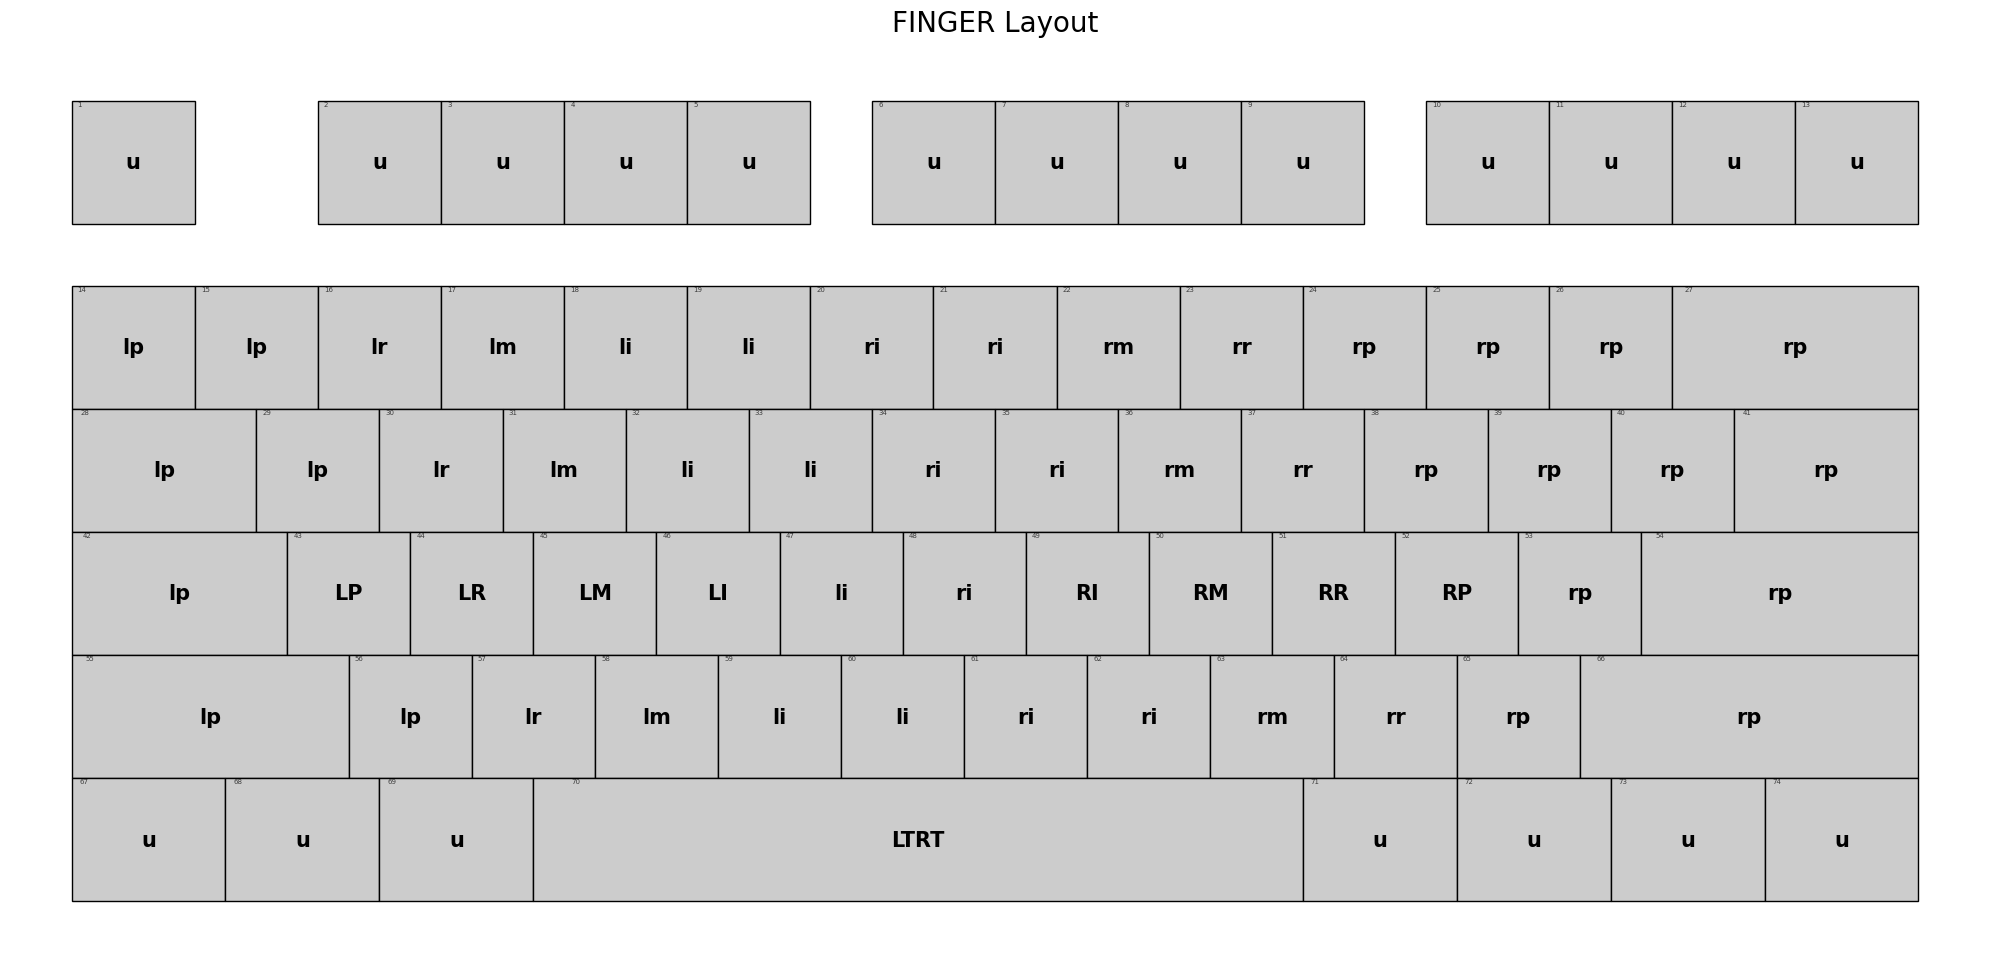

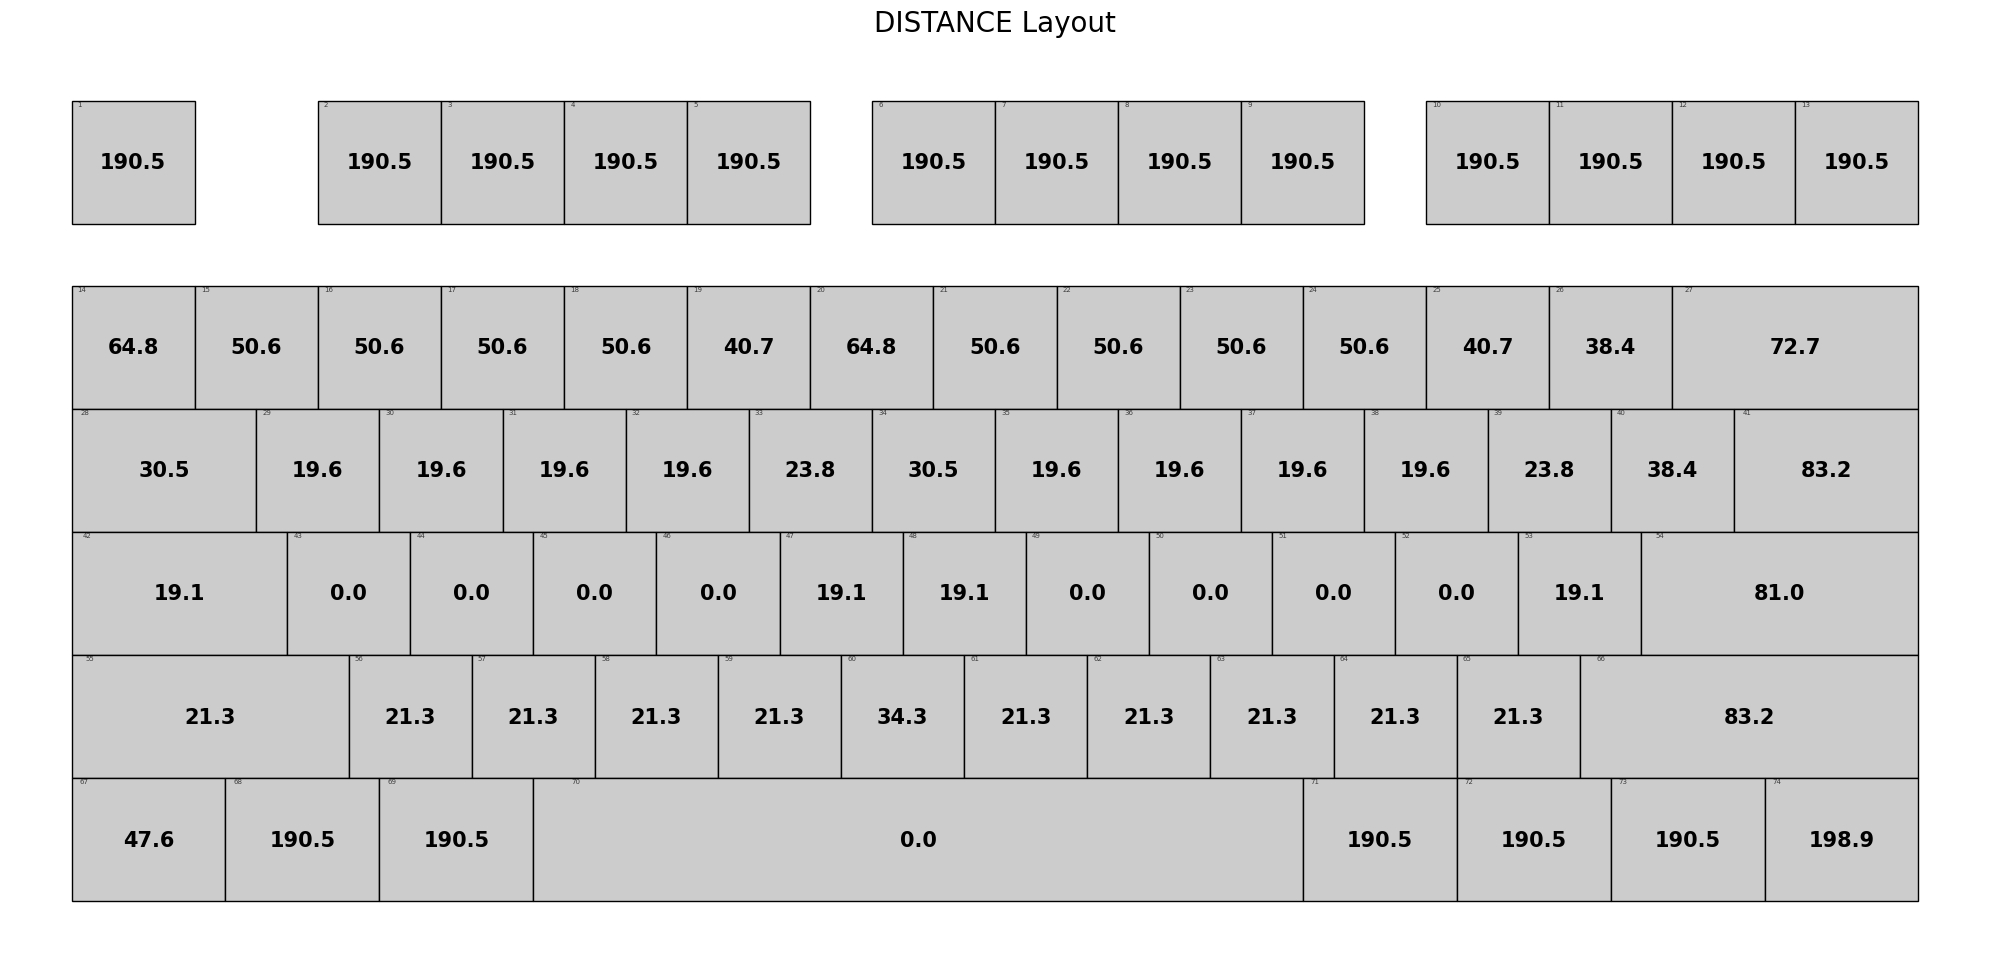

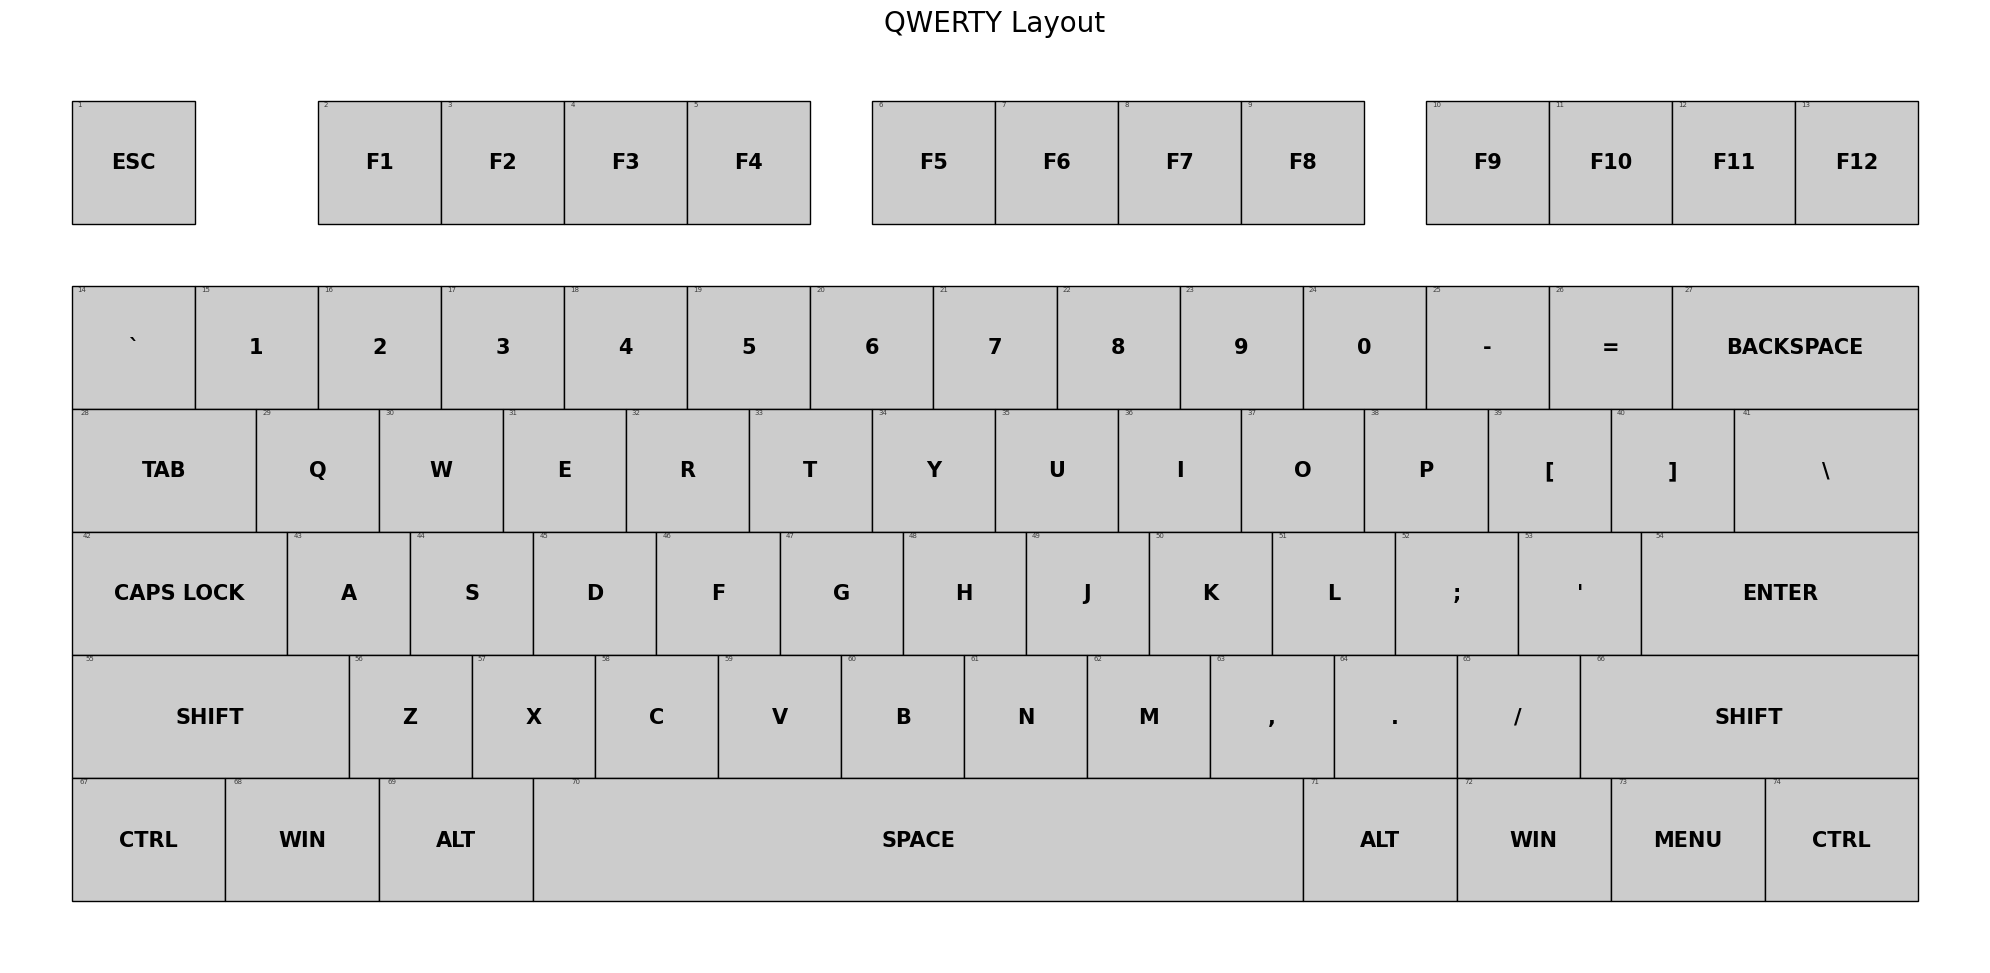

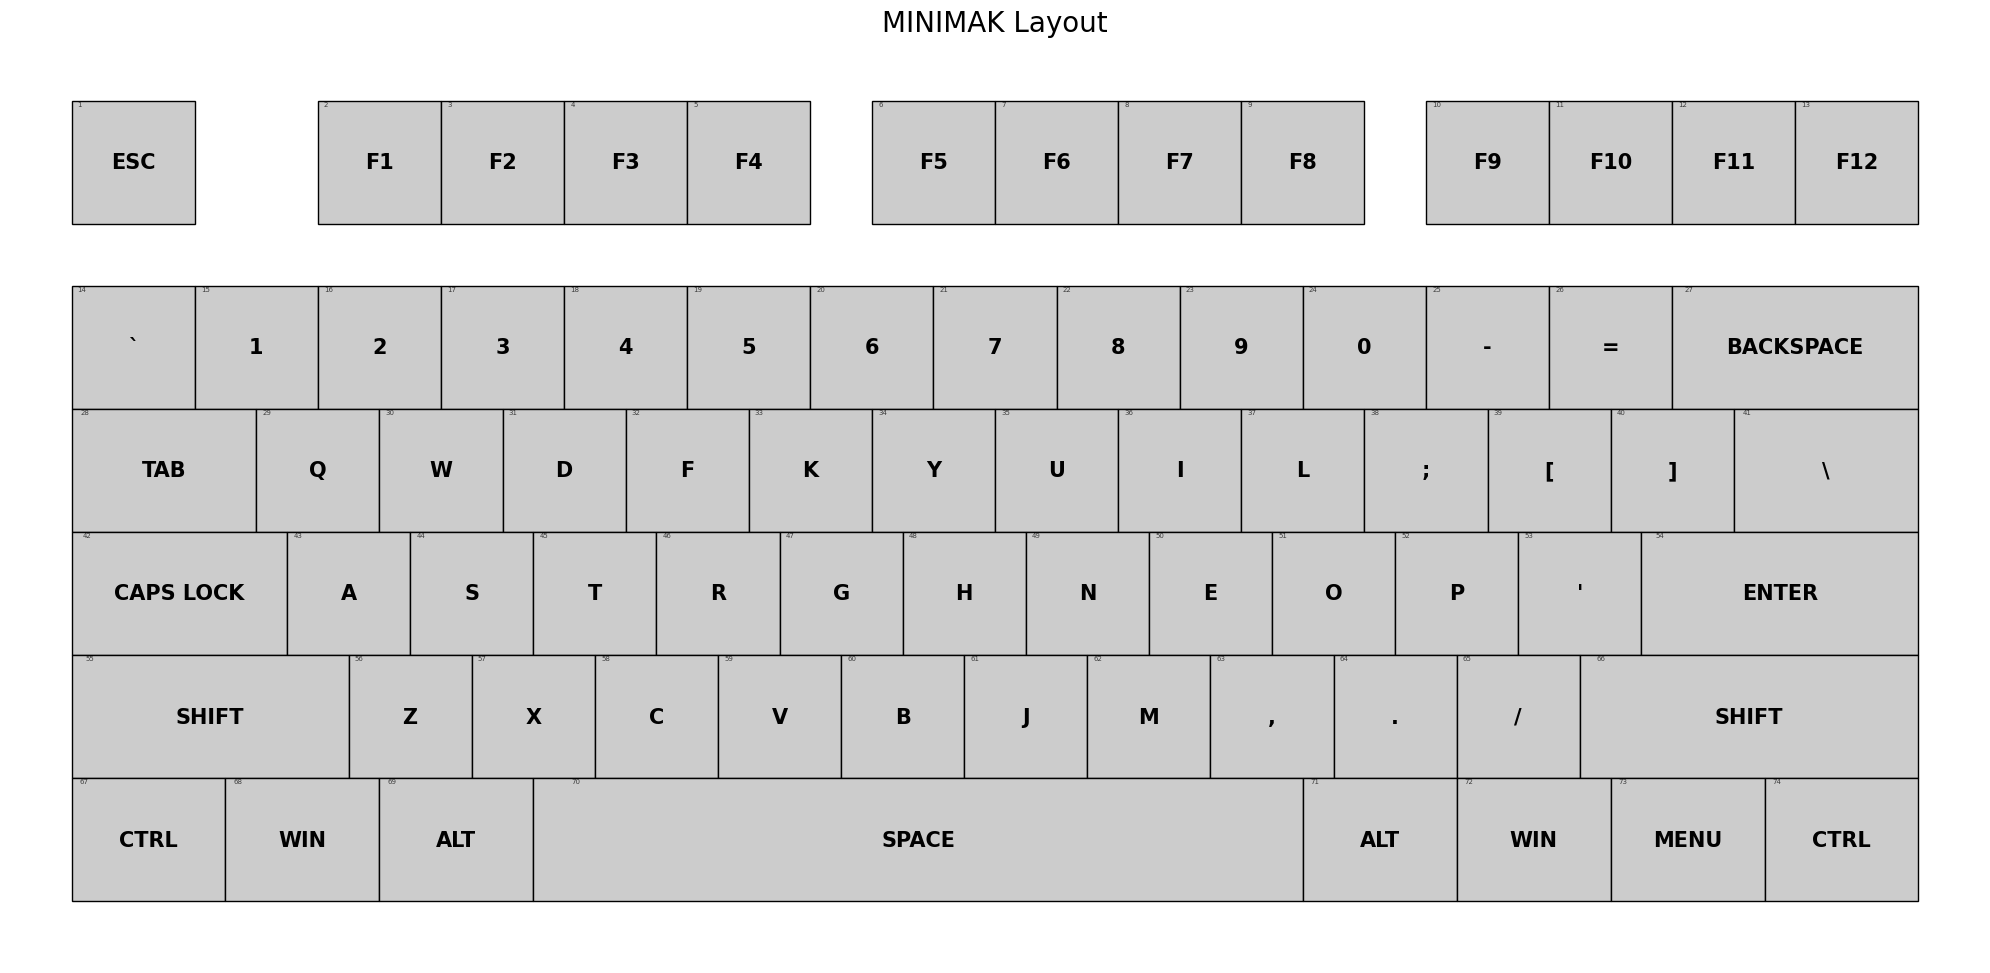

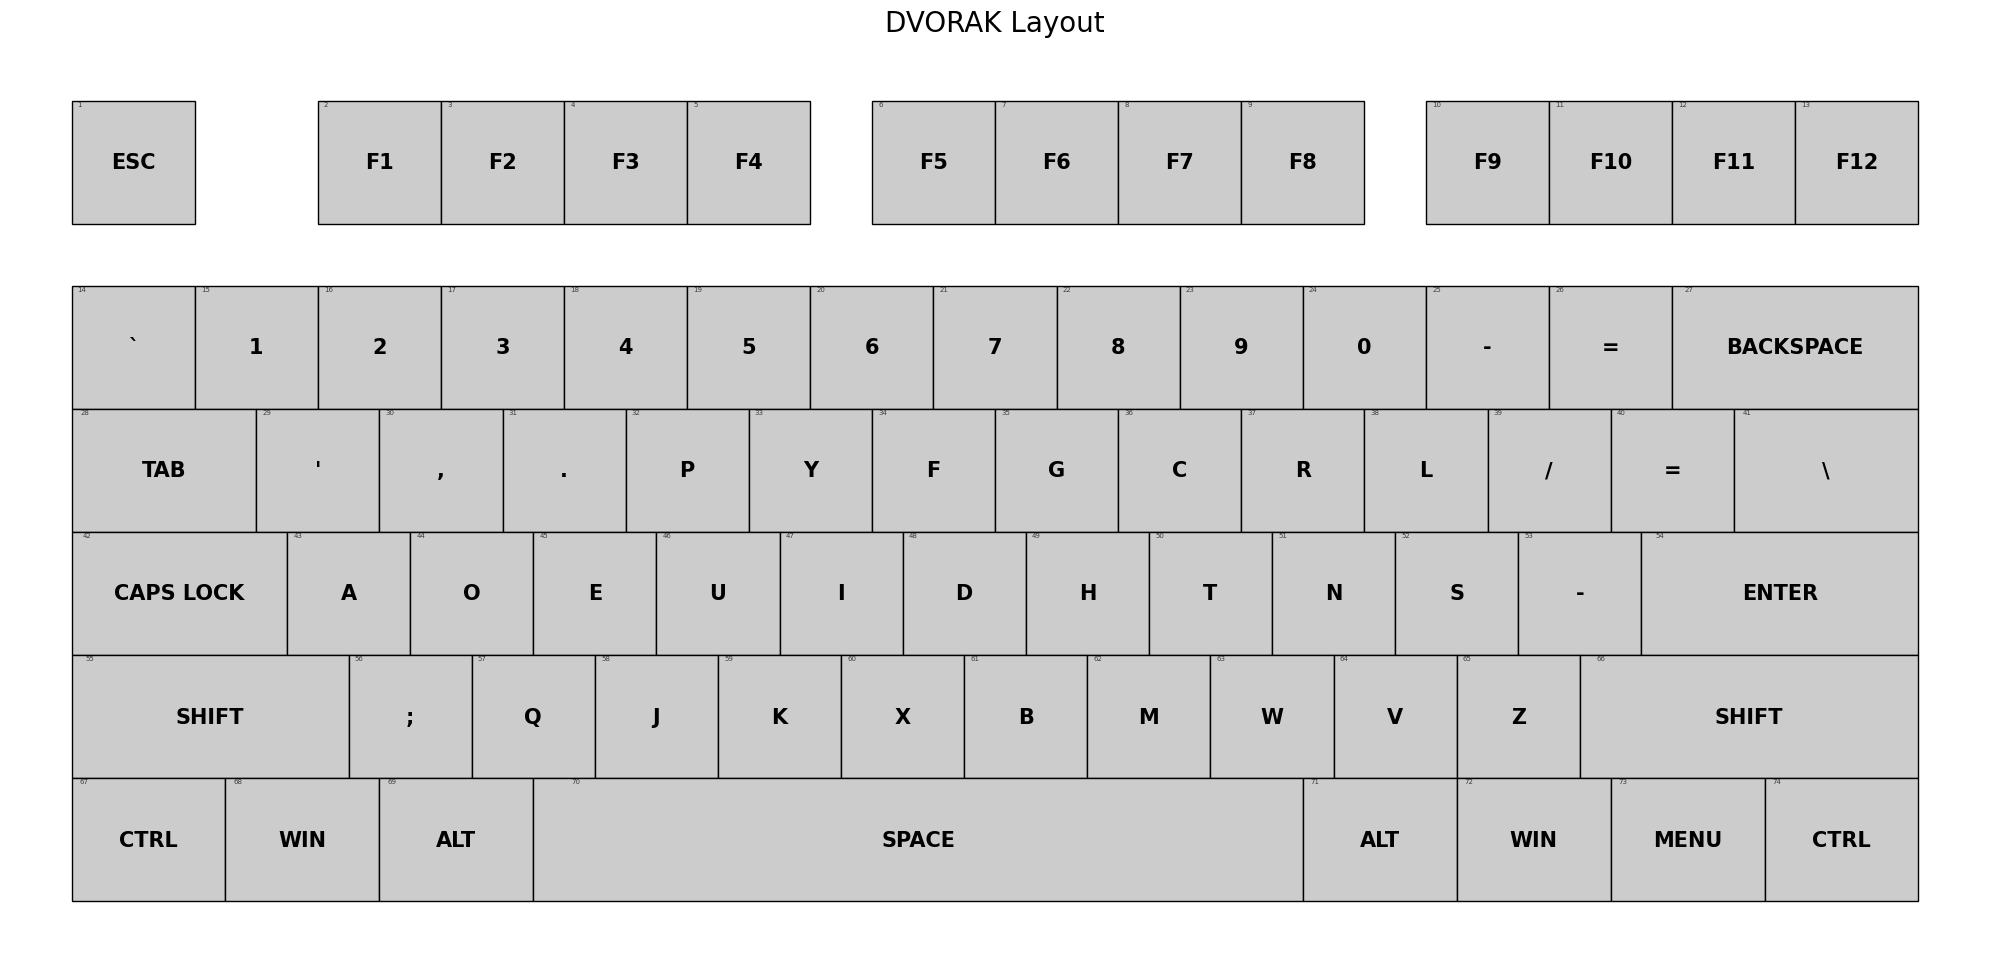

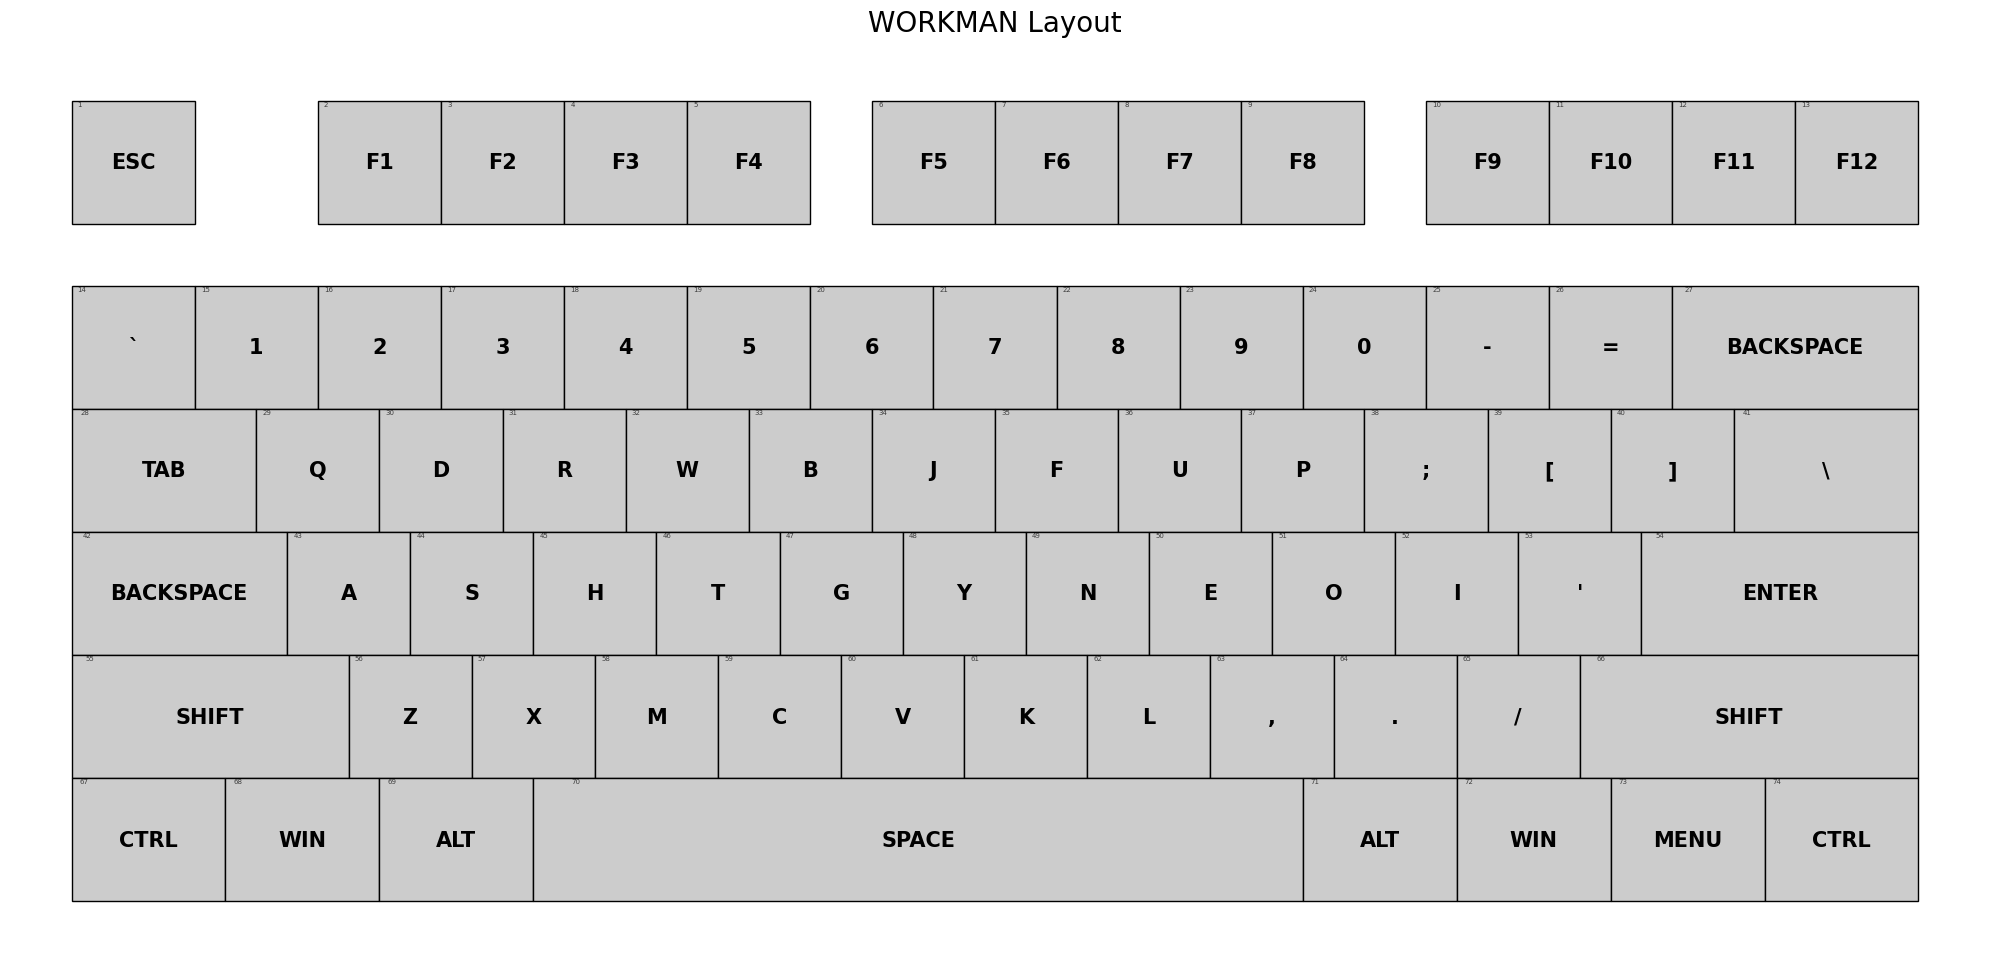

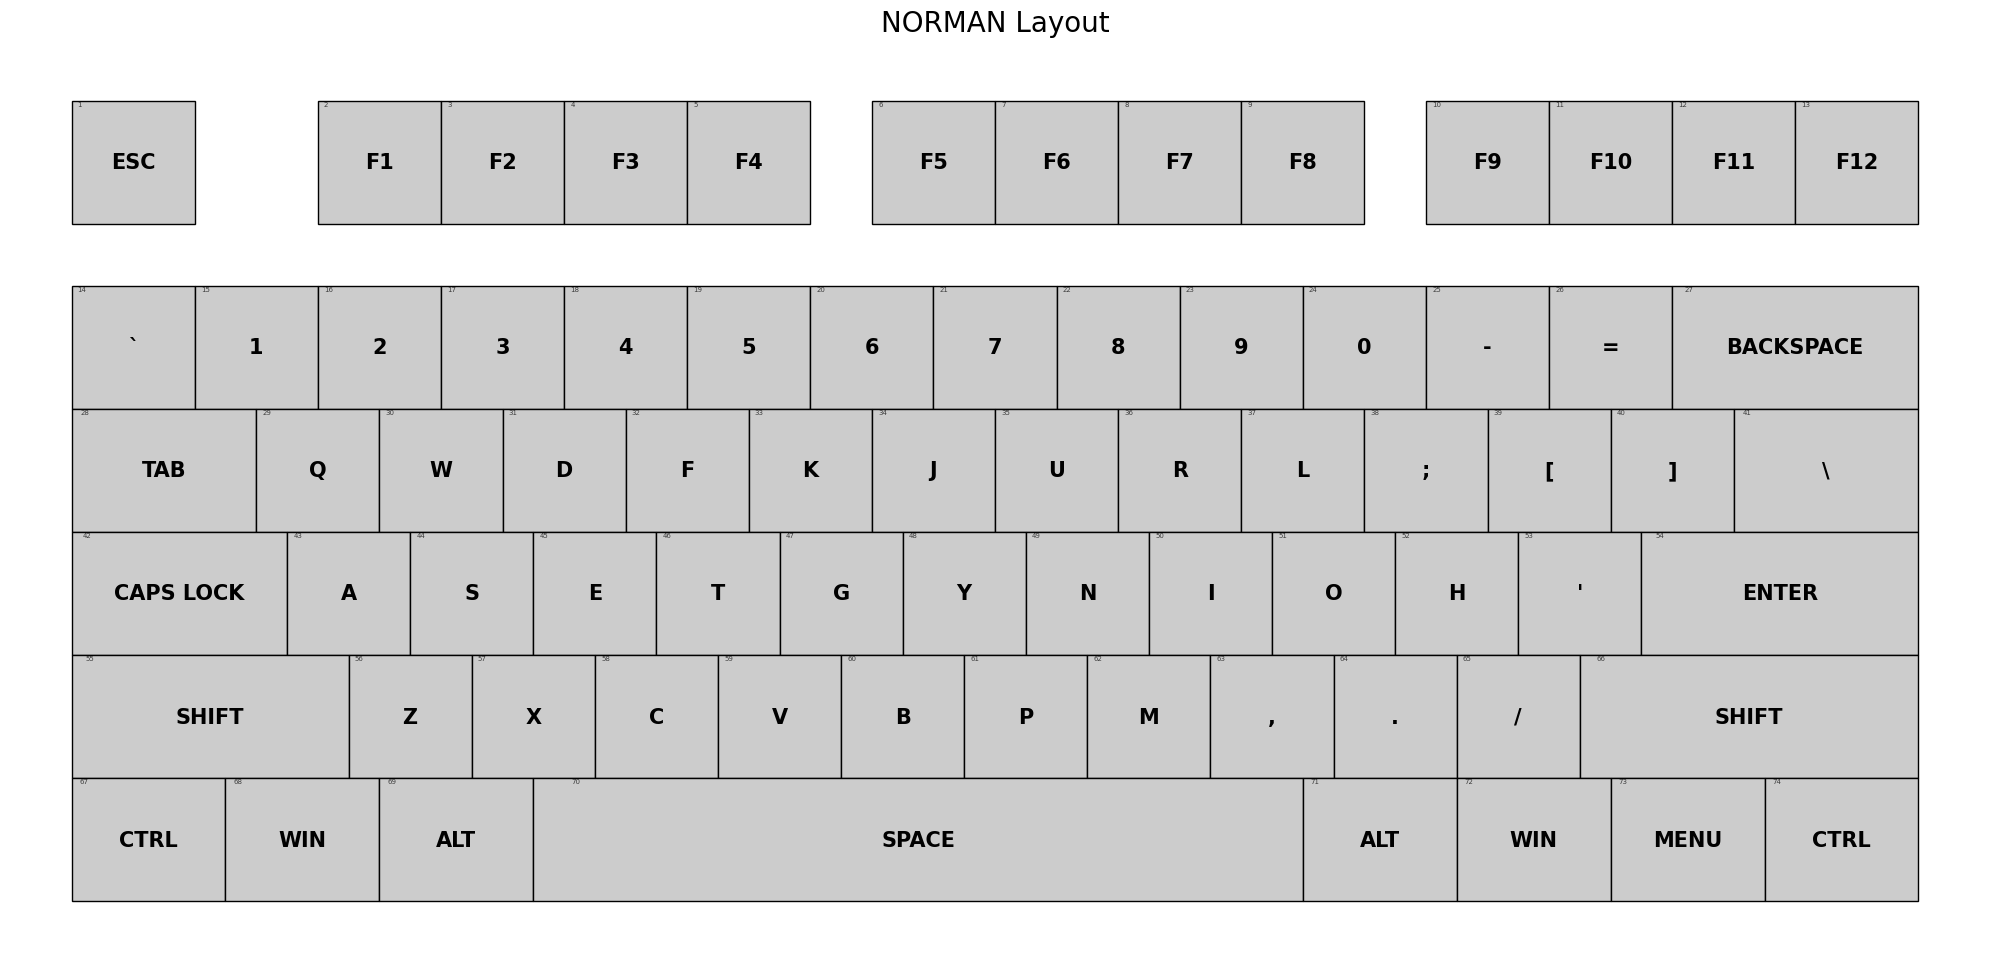

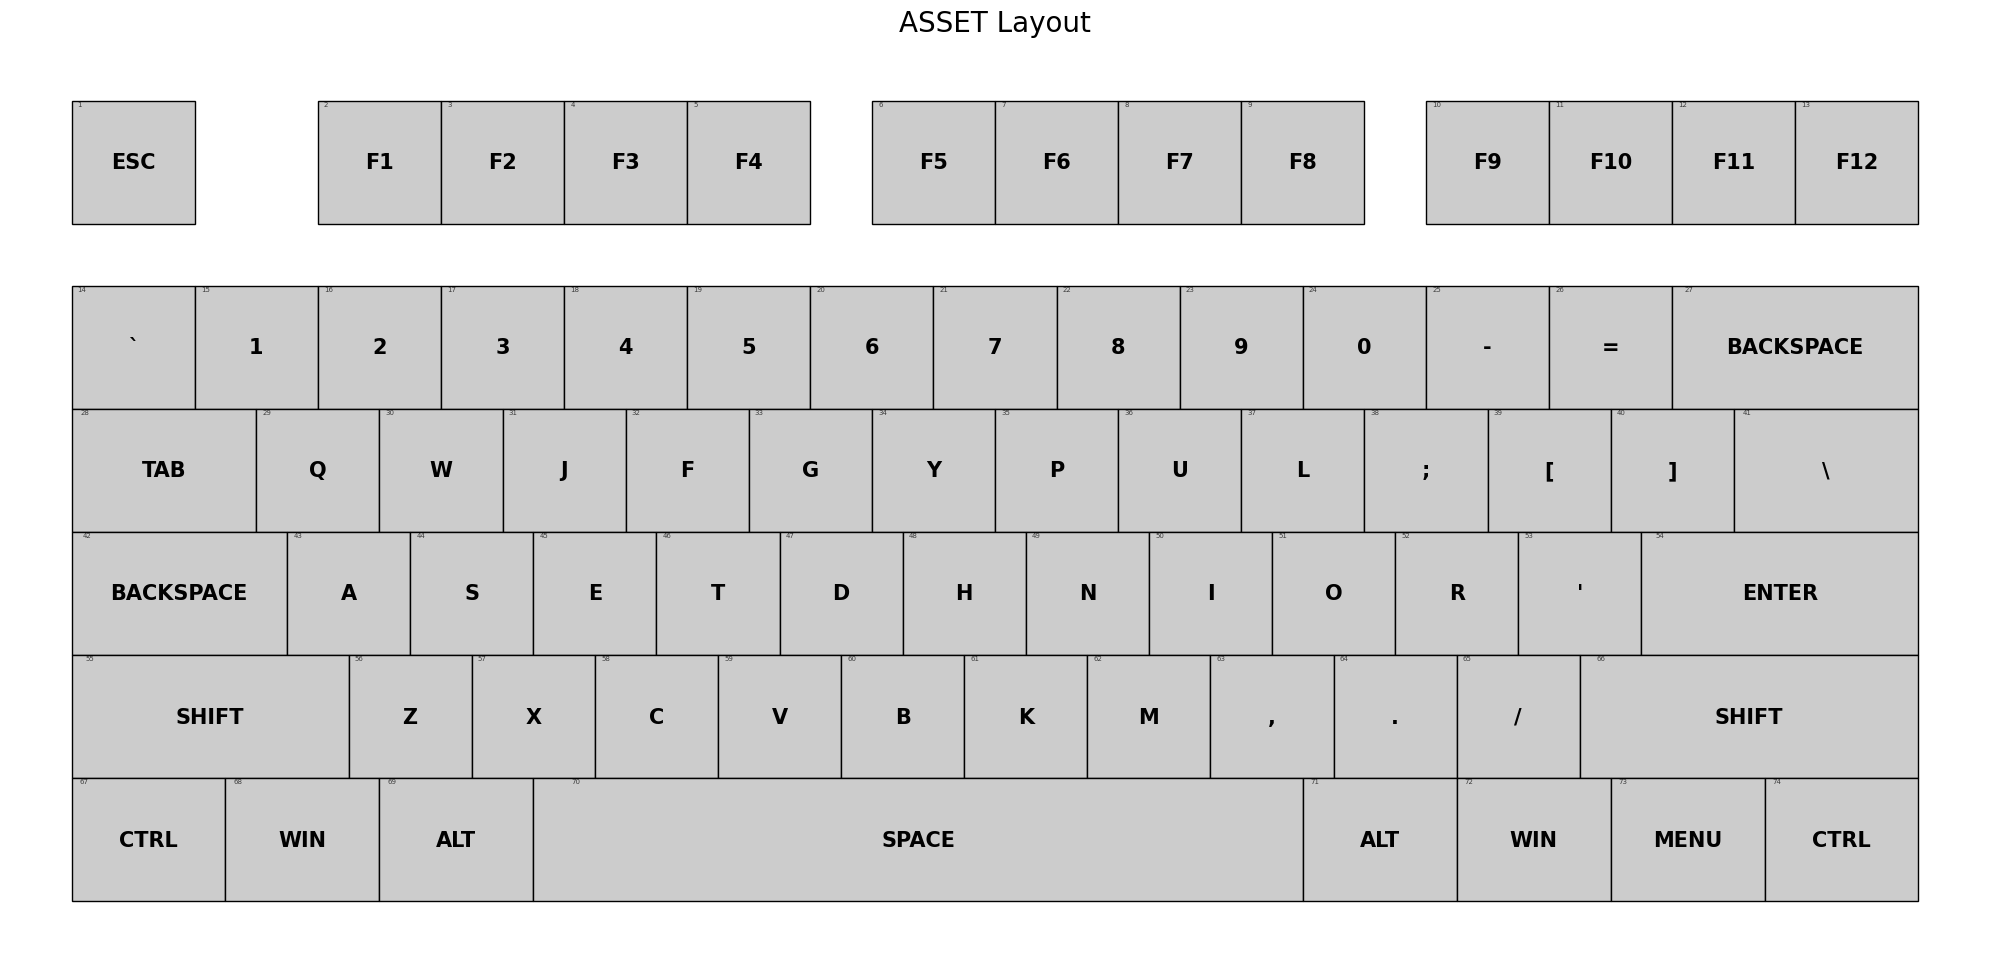

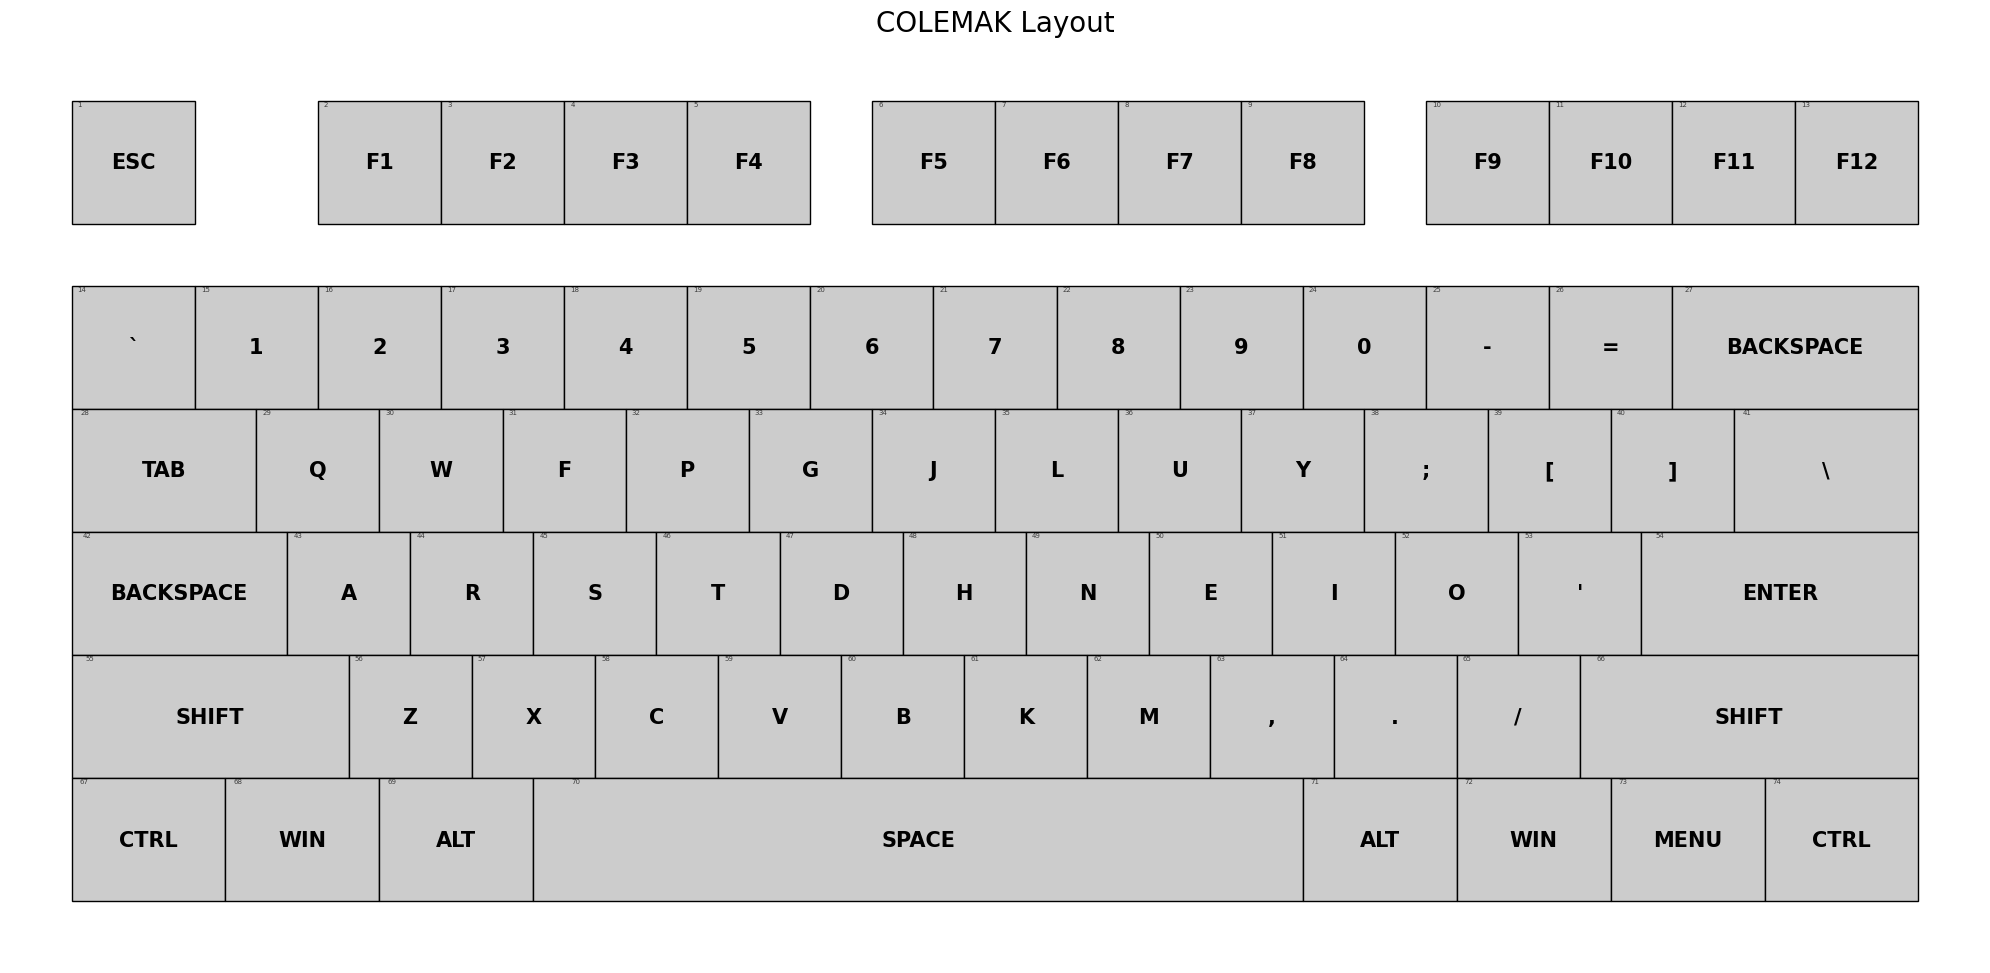

In [ ]:
for layout in layout_data.keys():
    print_layout(layout)

In [ ]:
touch_typing_mapping = [
	["Esc",{x:1},"F1","F2","F3","F4",{x:0.5},"F5","F6","F7","F8",{x:0.5},"F9","F10","F11","F12"],
	[{y:0.5},"lp|~\n`","lp|!\n1","lr|@\n2","lm|#\n3","li|$\n4","li|%\n5","ri|^\n6","ri|&\n7","rm|*\n8","rr|(\n9","rp|)\n0","rp|_\n-","rp|+\n=",{w:2},"rp|Backspace"],
	[{w:1.5},"lp|Tab","lp|Q","lr|W","lm|E","li|R","li|T","ri|Y","ri|U","rm|I","rr|O","rp|P","rp|{\n[","rp|}\n]",{w:1.5},"rp||\n\\"],
	[{w:1.75},"lp|Caps Lock","LP|A","LR|S","LM|D","LI|F","li|G","ri|H","RI|J","RM|K","RR|L","RP|:\n;","rp|\"\n'",{w:2.25},"rp|Enter"],
	[{w:2.25},"lp|Shift","lp|Z","lr|X","lm|C","li|V","li|B","ri|N","ri|M","rm|<\n,","rr|>\n.","rp|?\n/",{w:2.75},"rp|Shift"],
	[{w:1.25},"Ctrl",{w:1.25},"Win",{w:1.25},"Alt",{a:7,w:6.25},"LT|RT",{a:4,w:1.25},"Alt",{w:1.25},"Win",{w:1.25},"Menu",{w:1.25},"Ctrl"]
]

In [ ]:
if not layout_data:
    print("No layout data provided.")
else:
    first_layout_name = next(iter(layout_data))
    first_layout = layout_data[first_layout_name]
    num_keys = len(first_layout)

    for i in range(num_keys):
        key_counts = {}
        for layout_name, layout in layout_data.items():
            if i < len(layout):
                key = layout[i]
                key_counts[key] = key_counts.get(key, 0) + 1

        if len(key_counts) > 1:
            qwerty_key = ""
            if i < len(layout_data.get("QWERTY", [])):
                qwerty_key = f"(QWERTY: '{layout_data['QWERTY'][i]}')"

            print(f"--- Index {i} {qwerty_key} ---")
            for key, count in sorted(key_counts.items(), key=lambda item: item[1], reverse=True):
                print(f"Key '{key}': {count} times")
            print()

--- Index 0 (QWERTY: 'ESC') ---
Key 'ESC': 7 times
Key 'u': 1 times
Key '190.5': 1 times

--- Index 1 (QWERTY: 'F1') ---
Key 'F1': 7 times
Key 'u': 1 times
Key '190.5': 1 times

--- Index 2 (QWERTY: 'F2') ---
Key 'F2': 7 times
Key 'u': 1 times
Key '190.5': 1 times

--- Index 3 (QWERTY: 'F3') ---
Key 'F3': 7 times
Key 'u': 1 times
Key '190.5': 1 times

--- Index 4 (QWERTY: 'F4') ---
Key 'F4': 7 times
Key 'u': 1 times
Key '190.5': 1 times

--- Index 5 (QWERTY: 'F5') ---
Key 'F5': 7 times
Key 'u': 1 times
Key '190.5': 1 times

--- Index 6 (QWERTY: 'F6') ---
Key 'F6': 7 times
Key 'u': 1 times
Key '190.5': 1 times

--- Index 7 (QWERTY: 'F7') ---
Key 'F7': 7 times
Key 'u': 1 times
Key '190.5': 1 times

--- Index 8 (QWERTY: 'F8') ---
Key 'F8': 7 times
Key 'u': 1 times
Key '190.5': 1 times

--- Index 9 (QWERTY: 'F9') ---
Key 'F9': 7 times
Key 'u': 1 times
Key '190.5': 1 times

--- Index 10 (QWERTY: 'F10') ---
Key 'F10': 7 times
Key 'u': 1 times
Key '190.5': 1 times

--- Index 11 (QWERTY: 'F11'

In [ ]:
frequency_model = {
    'SPACE': 12002220, 'e': 5553777, 't': 4087691, 'o': 3646092, 'a': 3596011, 'i': 3232310, 'n': 3130128, 's': 3005185, 'r': 2855254, 'h': 2078026, 'l': 1897500, 'd': 1653619, 'c': 1546331, 'u': 1507855, 'm': 1257084, '.': 1147734, 'p': 988835, '-': 971639, 'g': 906175, 'y': 894257, 'f': 859697, 'w': 838507, 'b': 715946, 'SHIFT': 7336538, ',': 532618, 'v': 495777, 'k': 396061, "'": 357164, '1': 305164, '0': 266174, '=': 252645, '2': 203868, '3': 181301, '5': 164242, '9': 158445, '4': 156124, '6': 135750, '8': 131040, 'x': 123402, '7': 119420, '/': 113107, 'j': 110558, 'z': 57014, '\\': 51683, ';': 51003, 'q': 48254, ']': 44545, '[': 42156
}

In [ ]:
base_kle_data = [
    ["Esc",{x:1},"F1","F2","F3","F4",{x:0.5},"F5","F6","F7","F8",{x:0.5},"F9","F10","F11","F12"],
    [{y:0.5},"~\n`","!\n1","@\n2","#\n3","$\n4","%\n5","^\n6","&\n7","*\n8","(\n9",")\n0","_\n-","+\n=",{w:2},"Backspace"],
    [{w:1.5},"Tab","Q","W","E","R","T","Y","U","I","O","P","{\n[","}\n]",{w:1.5},"|\n\\"],
    [{w:1.75},"Caps Lock","A","S","D","F","G","H","J","K","L",":\n;","\"\n'",{w:2.25},"Enter"],
    [{w:2.25},"Shift","Z","X","C","V","B","N","M","<\n,",">\n.","?\n/",{w:2.75},"Shift"],
    [{w:1.25},"Ctrl",{w:1.25},"Win",{w:1.25},"Alt",{a:7,w:6.25},"",{a:4,w:1.25},"Alt",{w:1.25},"Win",{w:1.25},"Menu",{w:1.25},"Ctrl"]
]

In [ ]:
layout_data.keys()

dict_keys(['FINGER', 'DISTANCE', 'QWERTY', 'MINIMAK', 'DVORAK', 'WORKMAN', 'NORMAN', 'ASSET', 'COLEMAK'])

In [ ]:
physical_layout = [
["key0",{x:1},"key1","key2","key3","key4",{x:0.5},"key5","key6","key7","key8",{x:0.5},"key9","key10","key11","key12"],
[{y:0.5},"key13","key14","key15","key16","key17","key18","key19","key20","key21","key22","key23","key24","key25",{w:2},"key26"],
[{w:1.5},"key27","key28","key29","key30","key31","key32","key33","key34","key35","key36","key37","key38","key39",{w:1.5},"key40"],
[{w:1.75},"key41","key42","key43","key44","key45","key46","key47","key48","key49","key50","key51","key52",{w:2.25},"key53"],
[{w:2.25},"key54","key55","key56","key57","key58","key59","key60","key61","key62","key63","key64",{w:2.75},"key65"],
[{w:1.25},"key66",{w:1.25},"key67",{w:1.25},"key68",{a:7,w:6.25},"key69",{a:4,w:1.25},"key70",{w:1.25},"key71",{w:1.25},"key72",{w:1.25},"key73"]
]

In [ ]:
def physical_to_coordinates(physical_layout):
    coordinate_dict = {}
    y_offset = 0
    for row in physical_layout:
        x_offset = 0
        for value in row:
            if isinstance(value, dict):
                # Apply modifiers
                if "x" in value:
                    x_offset += value["x"]
                if "y" in value:
                    y_offset += value["y"]
                if "w" in value:
                    x_offset += value["w"]
            else:
                # Store the key position
                coordinate_dict[value] = (x_offset, y_offset)
                x_offset += 1  # Default width for each key    
        y_offset += 1
    return coordinate_dict
    
# physical_to_coordinates(kle_physical_layout)

In [ ]:
touch_typing_mapping = {
	"key0" : "u", "key1" : "u", "key2" : "u", "key3" : "u", "key4" : "u", "key5" : "u", "key6" : "u", "key7" : "u", "key8" : "u", "key9" : "u", "key10": "u", "key11": "u", "key12": "u",
	"key13": "lp", "key14": "lp", "key15": "lr", "key16": "lm", "key17": "li", "key18": "li", "key19": "ri", "key20": "ri", "key21": "rm", "key22": "rr", "key23": "rp", "key24": "rp", "key25": "rp", "key26": "rp",
	"key27": "lp", "key28": "lp", "key29": "lr", "key30": "lm", "key31": "li", "key32": "li", "key33": "ri", "key34": "ri", "key35": "rm", "key36": "rr", "key37": "rp", "key38": "rp", "key39": "rp", "key40": "rp",
	"key41": "lp", "key42": "LP", "key43": "LR", "key44": "LM", "key45": "LI", "key46": "li", "key47": "ri", "key48": "RI", "key49": "RM", "key50": "RR", "key51": "RP", "key52": "rp", "key53": "rp",
	"key54": "lp", "key55": "lp", "key56": "lr", "key57": "lm", "key58": "li", "key59": "li", "key60": "ri", "key61": "ri", "key62": "rm", "key63": "rr", "key64": "rp", "key65": "rp",
	"key66": "lp", "key67": "u", "key68": "u", "key69": "LTRT", "key70": "u", "key71": "u", "key72": "u", "key73": "rp"
}

In [ ]:
def find_home_keys(touch_typing_mapping):
    home_key_dict = {}
    for key, value in touch_typing_mapping.items():
        if isinstance(value, str) and value and value.isupper():
            home_key_dict[value] = key
    return home_key_dict

# find_home_keys(touch_typing_mapping)

{'LP': 'key42',
 'LR': 'key43',
 'LM': 'key44',
 'LI': 'key45',
 'RI': 'key48',
 'RM': 'key49',
 'RR': 'key50',
 'RP': 'key51',
 'LTRT': 'key69'}

In [ ]:
from scipy.spatial.distance import euclidean
UNDEFINED_DISTANCE = 10
U = 19.05 # U is the standard size of a keycap and the gap between them in mm

def calculate_distances(physical_layout, touch_typing_mapping):
    distance_mapping = {}
    home_key_dict = find_home_keys(touch_typing_mapping)
    coordinate_dict = physical_to_coordinates(physical_layout)

    for key, value in touch_typing_mapping.items():
        if value.upper() in home_key_dict:
            point1 = coordinate_dict[key]
            point2 = coordinate_dict[home_key_dict[value.upper()]]
            distance_mapping[key] = round(euclidean(point1, point2) * U, 1)
        else:
            distance_mapping[key] = round(UNDEFINED_DISTANCE * U, 1)
    return distance_mapping
        
distance_mapping = calculate_distances(physical_layout, touch_typing_mapping)

In [ ]:
layout_distance = []
for key, value in distance_mapping.items():
    layout_distance.append(f"{value:>.1f}")
layout_distance

['190.5',
 '190.5',
 '190.5',
 '190.5',
 '190.5',
 '190.5',
 '190.5',
 '190.5',
 '190.5',
 '190.5',
 '190.5',
 '190.5',
 '190.5',
 '64.8',
 '50.6',
 '50.6',
 '50.6',
 '50.6',
 '40.7',
 '64.8',
 '50.6',
 '50.6',
 '50.6',
 '50.6',
 '40.7',
 '38.4',
 '72.7',
 '30.5',
 '19.6',
 '19.6',
 '19.6',
 '19.6',
 '23.8',
 '30.5',
 '19.6',
 '19.6',
 '19.6',
 '19.6',
 '23.8',
 '38.4',
 '83.2',
 '19.1',
 '0.0',
 '0.0',
 '0.0',
 '0.0',
 '19.1',
 '19.1',
 '0.0',
 '0.0',
 '0.0',
 '0.0',
 '19.1',
 '81.0',
 '21.3',
 '21.3',
 '21.3',
 '21.3',
 '21.3',
 '34.3',
 '21.3',
 '21.3',
 '21.3',
 '21.3',
 '21.3',
 '83.2',
 '47.6',
 '190.5',
 '190.5',
 '0.0',
 '190.5',
 '190.5',
 '190.5',
 '198.9']

In [ ]:
layout_data.keys()

dict_keys(['FINGER', 'DISTANCE', 'QWERTY', 'MINIMAK', 'DVORAK', 'WORKMAN', 'NORMAN', 'ASSET', 'COLEMAK'])

In [ ]:
def get_logical_layout_mapper(physical_layout, logical_layout, touch_typing_mapping):
    distance_mapping = calculate_distances(physical_layout, touch_typing_mapping)
    logical_mapping = {}
    for index, item in enumerate(logical_layout):
        logical_mapping[item] = distance_mapping[list(distance_mapping.keys())[index]]
    return logical_mapping

In [ ]:
asset_maping = get_logical_layout_mapper(physical_layout, layout_data["ASSET"], touch_typing_mapping)

In [ ]:
layouts_to_test = ['QWERTY', 'MINIMAK', 'DVORAK', 'WORKMAN', 'NORMAN', 'ASSET', 'COLEMAK']

In [ ]:
frequency_model = {
    'SPACE': 12002220, 'e': 5553777, 't': 4087691, 'o': 3646092, 'a': 3596011, 'i': 3232310, 'n': 3130128, 's': 3005185, 'r': 2855254, 'h': 2078026, 'l': 1897500, 'd': 1653619, 'c': 1546331, 'u': 1507855, 'm': 1257084, '.': 1147734, 'p': 988835, '-': 971639, 'g': 906175, 'y': 894257, 'f': 859697, 'w': 838507, 'b': 715946, 'SHIFT': 7336538, ',': 532618, 'v': 495777, 'k': 396061, "'": 357164, '1': 305164, '0': 266174, '=': 252645, '2': 203868, '3': 181301, '5': 164242, '9': 158445, '4': 156124, '6': 135750, '8': 131040, 'x': 123402, '7': 119420, '/': 113107, 'j': 110558, 'z': 57014, '\\': 51683, ';': 51003, 'q': 48254, ']': 44545, '[': 42156
}
total_characters = 70205926

In [ ]:
def calculate_finger_travel_distance(logical_mapping, frequency_model):
    total_travel = 0.0
    for key, value in frequency_model.items():
        total_travel += value * logical_mapping[key.upper()]
    return total_travel

In [ ]:
asset = calculate_finger_travel_distance(asset_maping, frequency_model)

1154902800.2999995

In [ ]:
def print_mm_in_si(mm):
  kilometers = mm / 1000000
  print(f"  {kilometers} km (kilometers)")

print_mm_in_si(70205926*2)

  140.411852 km (kilometers)


In [ ]:
distances = {}
for layout in layouts_to_test:
    print(f"###testing {layout}")
    mapping = get_logical_layout_mapper(physical_layout, layout_data[layout], touch_typing_mapping)
    distance = calculate_finger_travel_distance(mapping, frequency_model)
    distances[layout] = distance
    print_mm_in_si(distance)

###testing QWERTY
  1517.0083578000003 km (kilometers)
###testing MINIMAK
  1196.6207984 km (kilometers)
###testing DVORAK
  1171.7119833 km (kilometers)
###testing WORKMAN
  1160.9072394999996 km (kilometers)
###testing NORMAN
  1161.4249934999996 km (kilometers)
###testing ASSET
  1154.9028002999994 km (kilometers)
###testing COLEMAK
  1146.3604811999999 km (kilometers)


In [ ]:
distances = dict(sorted(distances.items(), key=lambda item: item[1]))

print(distances)

{'COLEMAK': 1146360481.1999998, 'ASSET': 1154902800.2999995, 'WORKMAN': 1160907239.4999995, 'NORMAN': 1161424993.4999995, 'DVORAK': 1171711983.3, 'MINIMAK': 1196620798.4, 'QWERTY': 1517008357.8000004}


{'COLEMAK': '100.00%', 'ASSET': '100.75%', 'WORKMAN': '101.27%', 'NORMAN': '101.31%', 'DVORAK': '102.21%', 'MINIMAK': '104.38%', 'QWERTY': '132.33%'}


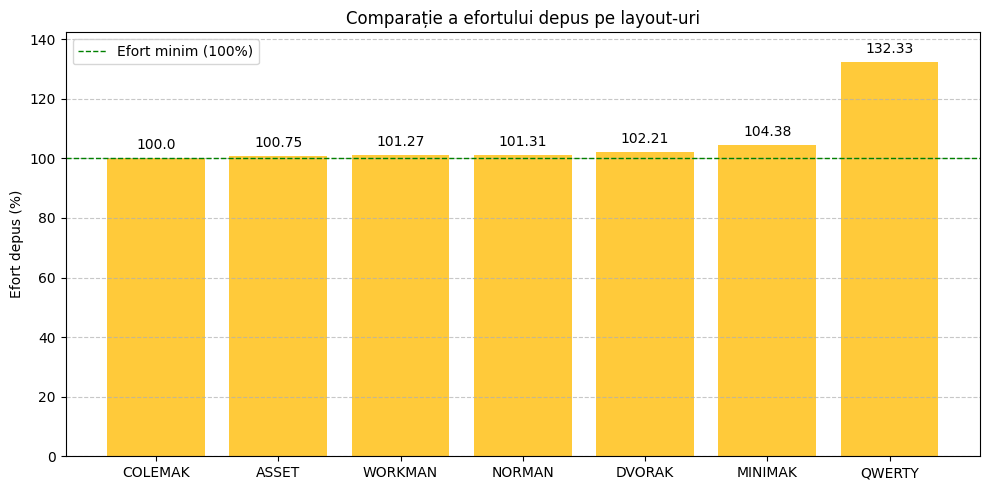

In [ ]:
import matplotlib.pyplot as plt

# Cel mai mic timp (cea mai mică distanță = cel mai puțin efort)
fastest_time = min(distances.values())

# Calculează efortul depus în procente (mai mic e mai bun)
percentage_distances = {}
for layout, distance in distances.items():
    percentage = (distance / fastest_time) * 100
    percentage_distances[layout] = f"{percentage:.2f}%"

# Sortează crescător după efort
sorted_percentage_distances = dict(sorted(percentage_distances.items(), key=lambda item: float(item[1][:-1])))

# Afișează efortul în procente
print(sorted_percentage_distances)

# Pregătire pentru grafic
layouts = list(sorted_percentage_distances.keys())
percentages = [float(p[:-1]) for p in sorted_percentage_distances.values()]

plt.figure(figsize=(10, 5))
bars = plt.bar(layouts, percentages, color='#ffca3a')
plt.ylabel("Efort depus (%)")
plt.title("Comparație a efortului depus pe layout-uri")
plt.ylim(0, max(percentages) + 10)
plt.axhline(100, color='green', linestyle='--', linewidth=1, label='Efort minim (100%)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Afișează procentul deasupra fiecărei bare
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 2, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()


COLEMAK: 100.00%
ASSET: 99.26%
WORKMAN: 98.75%
NORMAN: 98.70%
DVORAK: 97.84%
MINIMAK: 95.80%
QWERTY: 75.57%


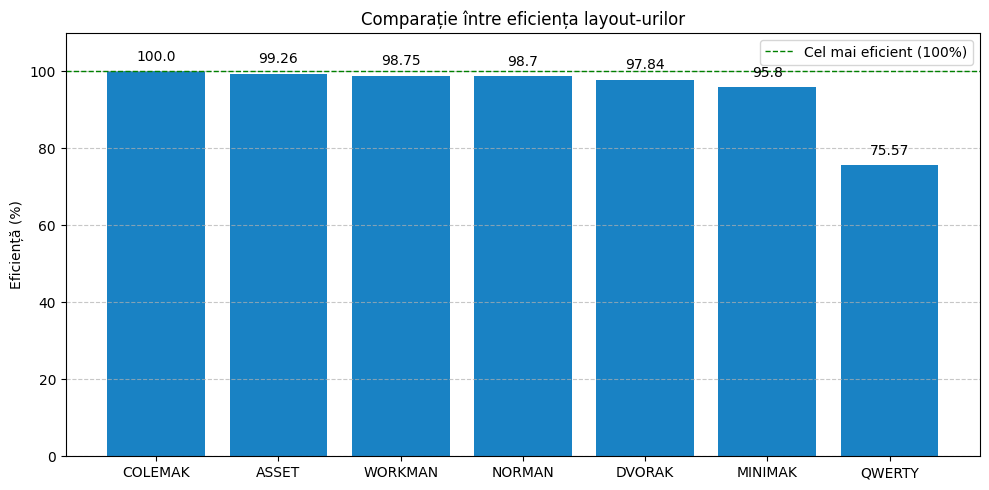

In [ ]:
import matplotlib.pyplot as plt

# Găsește timpul cel mai rapid (cea mai mică distanță)
fastest_time = min(distances.values())

# Calculează procentele de eficiență (mai mare este mai bine)
efficiency_percentages = {
    layout: (fastest_time / distance) * 100
    for layout, distance in distances.items()
}

# Sortează descrescător după eficiență (100% este cel mai bine)
sorted_efficiency = dict(sorted(efficiency_percentages.items(), key=lambda item: item[1], reverse=True))

# Afișează eficiența formatată
for layout, percentage in sorted_efficiency.items():
    print(f"{layout}: {percentage:.2f}%")

# Afișare grafic
layouts = list(sorted_efficiency.keys())
percentages = list(sorted_efficiency.values())

plt.figure(figsize=(10, 5))
bars = plt.bar(layouts, percentages, color='#1982c4')
plt.ylabel("Eficiență (%)")
plt.title("Comparație între eficiența layout-urilor")
plt.ylim(0, 110)
plt.axhline(100, color='green', linestyle='--', linewidth=1, label='Cel mai eficient (100%)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Afișează procentul deasupra fiecărei bare
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 2, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

color_map = {
    'LP': ('#cccccc', '#1982c4'),  # Light Gray to Gray
    'LR': ('#cccccc', '#8ac926'),  # Cyan to Aqua
    'LM': ('#cccccc', '#ffca3a'),  # Pale Cyan to Dark Turquoise
    'LI': ('#cccccc', '#6a4c93'),  # Light Blue to Blue
    'RI': ('#cccccc', '#ff595e'),  # Lemon Chiffon to Gold
    'RM': ('#cccccc', '#ffca3a'),  # Bisque to Chocolate
    'RR': ('#cccccc', '#8ac926'),  # Peachpuff to Dark Orange
    'RP': ('#cccccc', '#1982c4'),  # Lavender Blush to Hot Pink
    'LTRT': ('#cccccc', '#3d5a80') # Pale Green to Green
}

def create_and_plot_gradients(color_map: dict, steps: int = 1000):
    gradients = {}
    num_gradients = len(color_map)
    fig, axes = plt.subplots(num_gradients, 1, figsize=(10, num_gradients * 0.5))
    if num_gradients == 1:
        axes = [axes]  # Make sure axes is always a list for consistent indexing

    for i, (key, (start_hex, end_hex)) in enumerate(color_map.items()):
        start_rgb = mcolors.to_rgb(start_hex)
        end_rgb = mcolors.to_rgb(end_hex)
        cmap = mcolors.LinearSegmentedColormap.from_list(f"cmap_{key}", [start_rgb, end_rgb], N=steps)
        gradient_colors_rgb = [cmap(j) for j in range(steps)]

        # Store gradient for later access
        gradients[key] = {
            'gradient': np.array(gradient_colors_rgb),
            'start_hex': start_hex,
            'end_hex': end_hex
        }

        ax = axes[i]
        ax.imshow(np.array([gradient_colors_rgb]), aspect='auto')
        ax.set_title(f"Gradient for '{key}'")
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()

    return gradients

In [ ]:
def calculate_key_percentage(frequency_model, shift=False, space=False):
    usage_percentage_dict = {}
    total_count = 0
    factor = 1000
    
    for key, count in frequency_model.items():
        if shift and key == "SHIFT":
            total_count += count
        if space and key == "SPACE":
             total_count += count
        if key != "SHIFT" and key != "SPACE":
            total_count += count
    
    for key, count in frequency_model.items():
        if shift and key == "SHIFT":
            usage_percentage_dict[key] = int(count / total_count * factor)
        if space and key == "SPACE":
             usage_percentage_dict[key] = int(count / total_count * factor)
        if key != "SHIFT" and key != "SPACE":
         usage_percentage_dict[key] = int(count / total_count * factor)
    return(usage_percentage_dict)
    
key_percentage = calculate_key_percentage(frequency_model)
key_percentage

{'e': 109,
 't': 80,
 'o': 71,
 'a': 70,
 'i': 63,
 'n': 61,
 's': 59,
 'r': 56,
 'h': 40,
 'l': 37,
 'd': 32,
 'c': 30,
 'u': 29,
 'm': 24,
 '.': 22,
 'p': 19,
 '-': 19,
 'g': 17,
 'y': 17,
 'f': 16,
 'w': 16,
 'b': 14,
 ',': 10,
 'v': 9,
 'k': 7,
 "'": 7,
 '1': 5,
 '0': 5,
 '=': 4,
 '2': 4,
 '3': 3,
 '5': 3,
 '9': 3,
 '4': 3,
 '6': 2,
 '8': 2,
 'x': 2,
 '7': 2,
 '/': 2,
 'j': 2,
 'z': 1,
 '\\': 1,
 ';': 1,
 'q': 0,
 ']': 0,
 '[': 0}

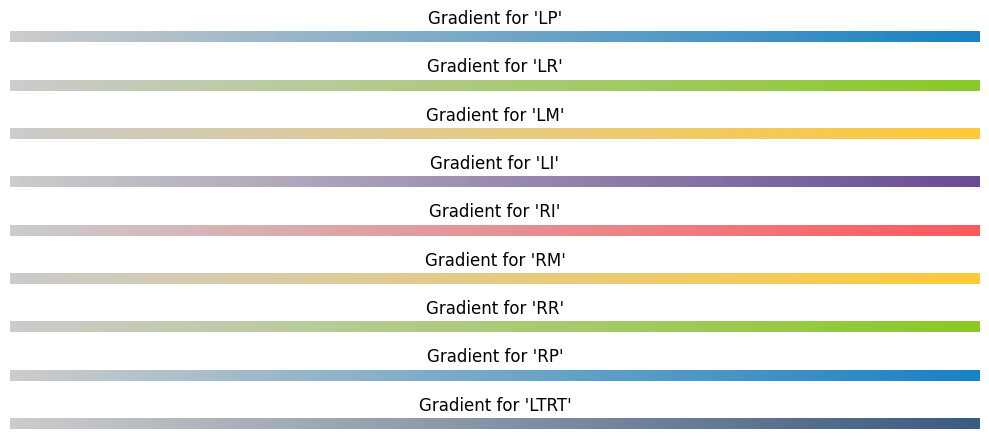

In [ ]:
# Get the gradients along with the color map for later use
gradients = create_and_plot_gradients(color_map, key_percentage[next(iter(key_percentage))] + 1)

In [ ]:
# gradients

In [ ]:
from collections import defaultdict
from matplotlib.patches import Patch

def print_layout(layout, key_percentage):
    finger_key_distribution = defaultdict(int)
    
    kle_data = [
        ["Esc",{x:1},"F1","F2","F3","F4",{x:0.5},"F5","F6","F7","F8",{x:0.5},"F9","F10","F11","F12"],
        [{y:0.5},"~\n`","!\n1","@\n2","#\n3","$\n4","%\n5","^\n6","&\n7","*\n8","(\n9",")\n0","_\n-","+\n=",{w:2},"Backspace"],
        [{w:1.5},"Tab","Q","W","E","R","T","Y","U","I","O","P","{\n[","}\n]",{w:1.5},"|\n\\"],
        [{w:1.75},"Caps Lock","A","S","D","F","G","H","J","K","L",":\n;","\"\n'",{w:2.25},"Enter"],
        [{w:2.25},"Shift","Z","X","C","V","B","N","M","<\n,",">\n.","?\n/",{w:2.75},"Shift"],
        [{w:1.25},"Ctrl",{w:1.25},"Win",{w:1.25},"Alt",{a:7,w:6.25},"",{a:4,w:1.25},"Alt",{w:1.25},"Win",{w:1.25},"Menu",{w:1.25},"Ctrl"]
    ]
    
    
    # Apply the Dvorak layout to the KLE data structure
    try:
        test_kle_data = map_layout_to_kle(kle_data, layout_data[layout])
    except KeyError as e:
        return
    except Exception as e:
        return
    
    # Parse the resulting KLE data
    if test_kle_data:
        try:
            physical_layout, logical_layout, color_layout = parse_kle_layout_spec_compliant(test_kle_data)
        except Exception as e:
            return

        for index, key in enumerate(layout_data[layout]):
            key_code = list(touch_typing_mapping.keys())[index]
            key_finger = touch_typing_mapping[key_code].upper()
            
            if key.lower() in key_percentage:
                finger_key_distribution[key_finger.upper()] += key_percentage[key.lower()]
            if key_finger.upper() in gradients:
                if key.lower() in key_percentage:
                    percentage = key_percentage[key.lower()]
                    if key_finger in gradients:
                        if index in color_layout:
                            color_layout[index+1] = gradients[key_finger.upper()]["gradient"][percentage]
        # Modify colors 
        try:
            draw_keyboard(physical_layout, logical_layout, color_layout, f"{layout} Layout")
        except Exception as e:
            print(f"Error while drawing the keyboard: {e}")
    else:
        print("Error: Could not map Dvorak layout to KLE data.")
    
    # Prelucrare date: procente
    fingers = list(finger_key_distribution.keys())
    values = [v / 10 for v in finger_key_distribution.values()]
    colors = [gradients[finger.upper()]["gradient"][-1] for finger in fingers]
    
    # Plotare grafic
    plt.figure(figsize=(10, 5))
    bars = plt.bar(fingers, values, color=colors)
    
    plt.ylabel("Efort în procente (%)")
    plt.title("Distribuția efortului pe degete")
    plt.ylim(0, max(values) + 10)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    
    # Afișare valori pe bare
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.1f}%", ha='center', va='bottom')
    
    # Legendă explicativă
    legend_elements = [
        Patch(facecolor=gradients['LP']['gradient'][-1], label='LP - stânga mic'),
        Patch(facecolor=gradients['LR']['gradient'][-1], label='LR - stânga inelar'),
        Patch(facecolor=gradients['LM']['gradient'][-1], label='LM - stânga mijlociu'),
        Patch(facecolor=gradients['LI']['gradient'][-1], label='LI - stânga arătător'),
        Patch(facecolor=gradients['RI']['gradient'][-1], label='RI - dreapta arătător'),
        Patch(facecolor=gradients['RM']['gradient'][-1], label='RM - dreapta mijlociu'),
        Patch(facecolor=gradients['RR']['gradient'][-1], label='RR - dreapta inelar'),
        Patch(facecolor=gradients['RP']['gradient'][-1], label='RP - dreapta mic'),
    ]
    
    plt.legend(handles=legend_elements, title="Degete", loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    return finger_key_distribution


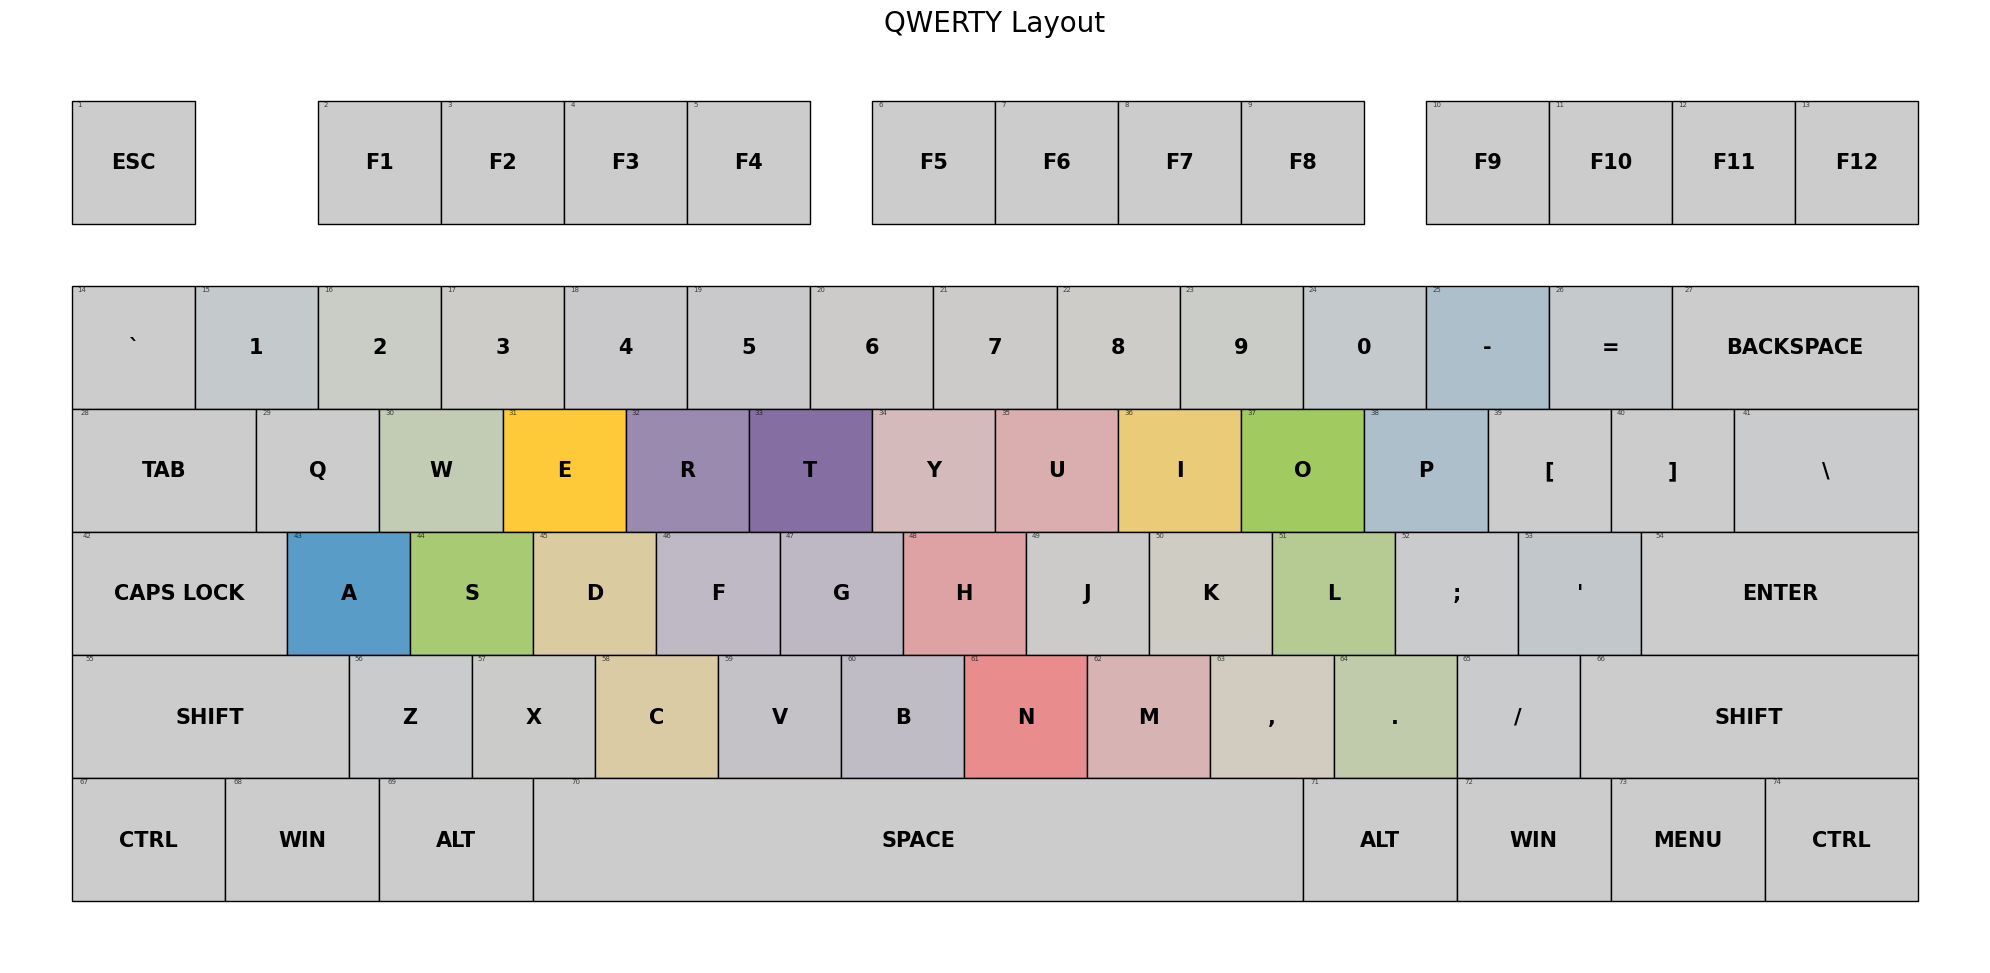

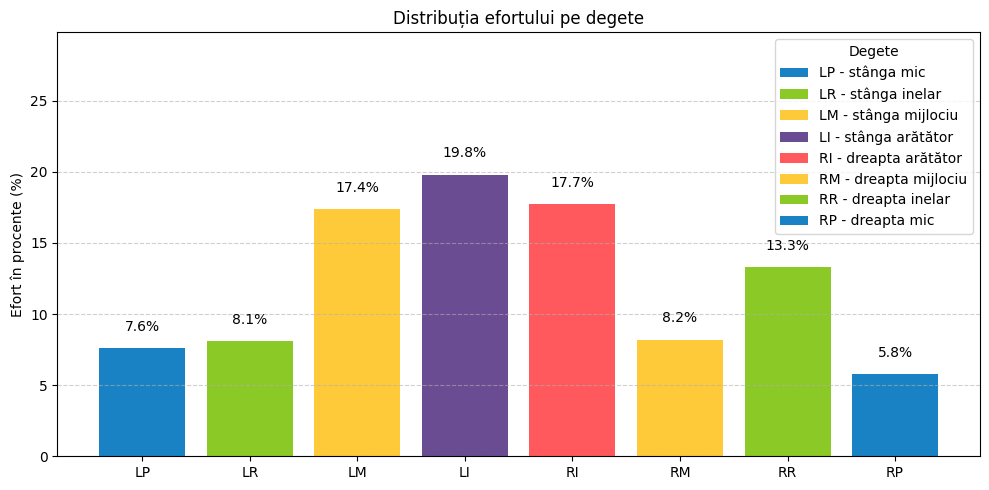

defaultdict(<class 'int'>, {'LP': 76, 'LR': 81, 'LM': 174, 'LI': 198, 'RI': 177, 'RM': 82, 'RR': 133, 'RP': 58})


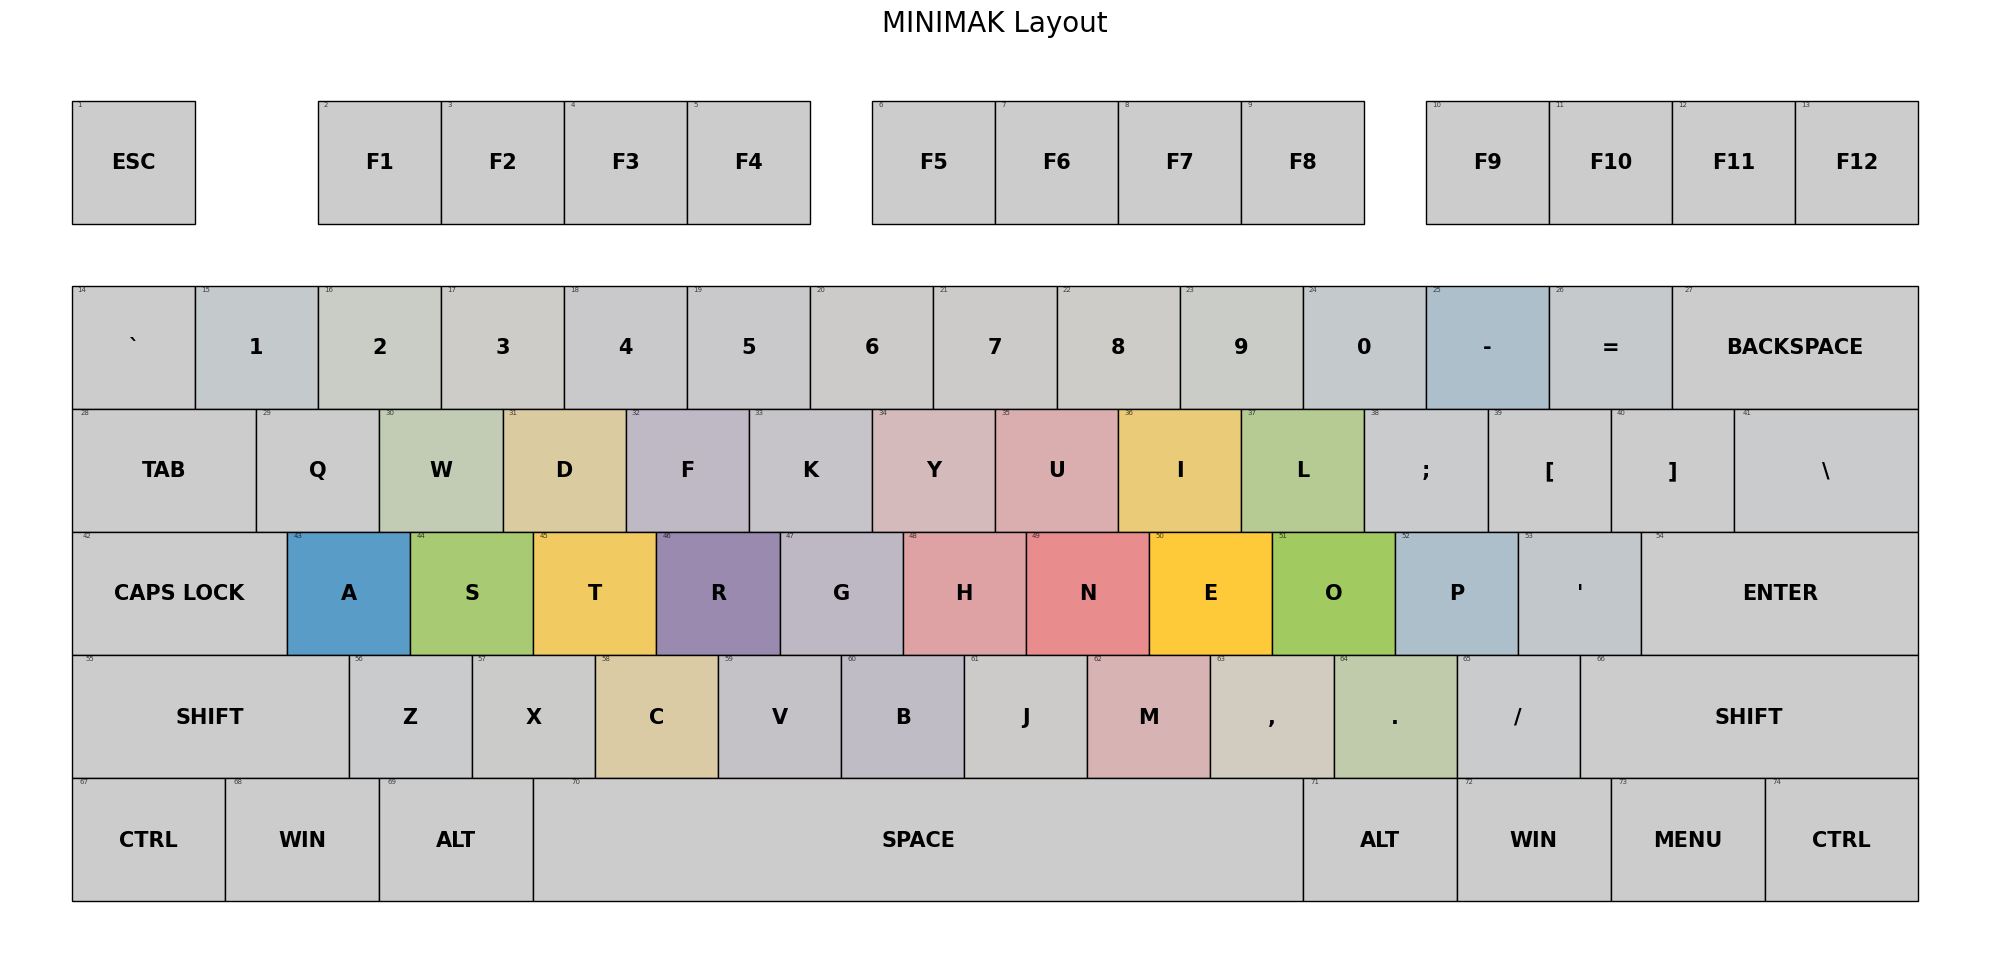

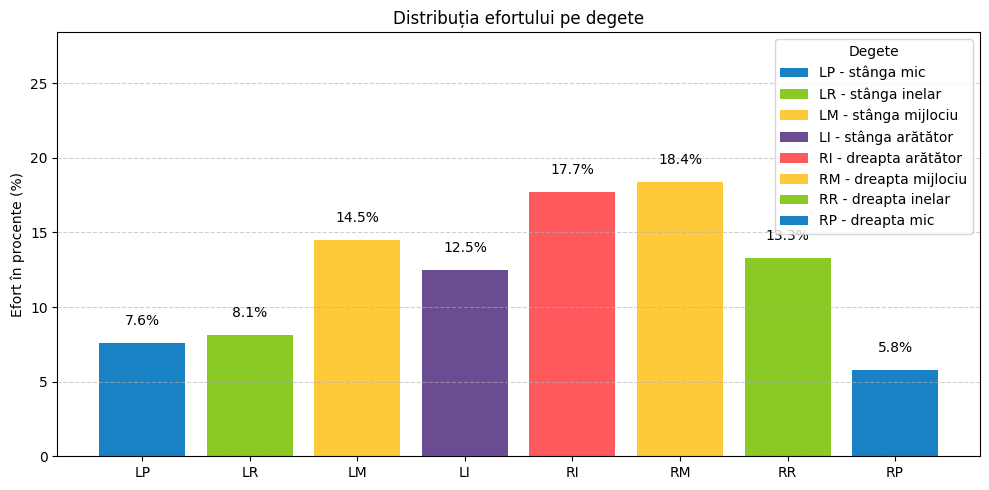

defaultdict(<class 'int'>, {'LP': 76, 'LR': 81, 'LM': 145, 'LI': 125, 'RI': 177, 'RM': 184, 'RR': 133, 'RP': 58})


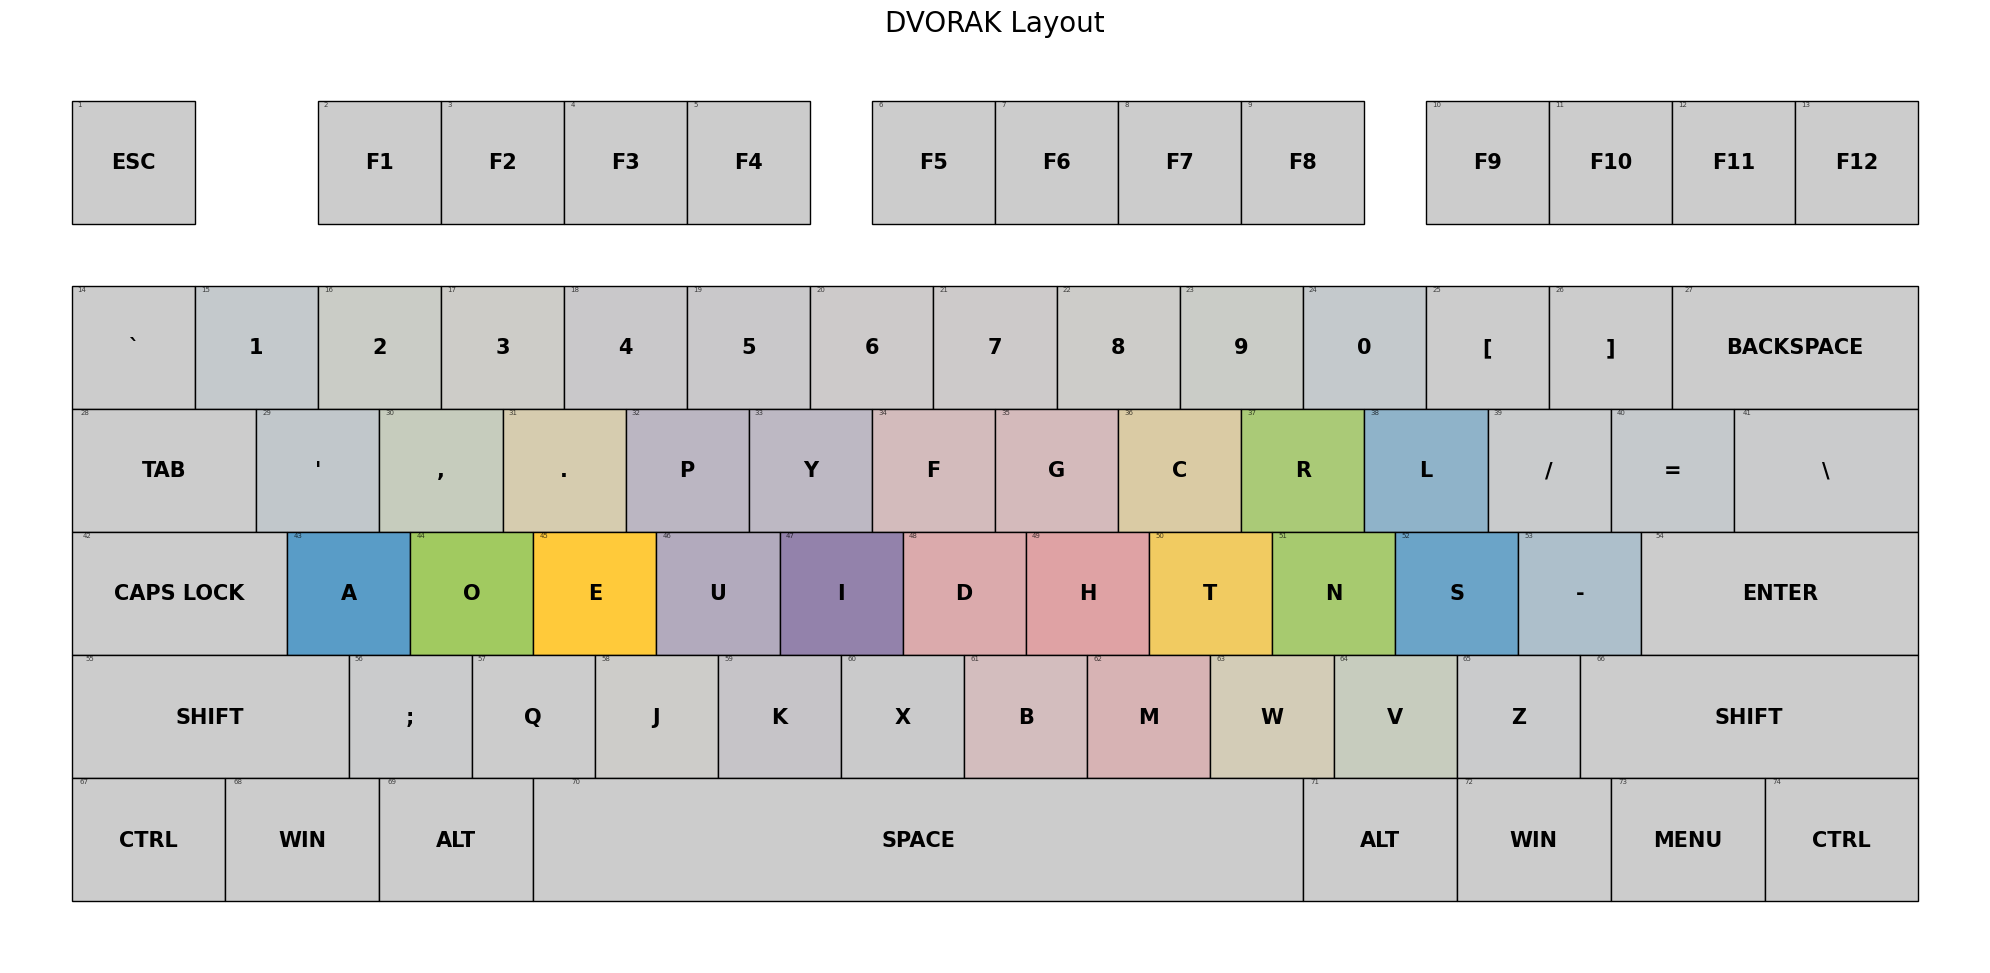

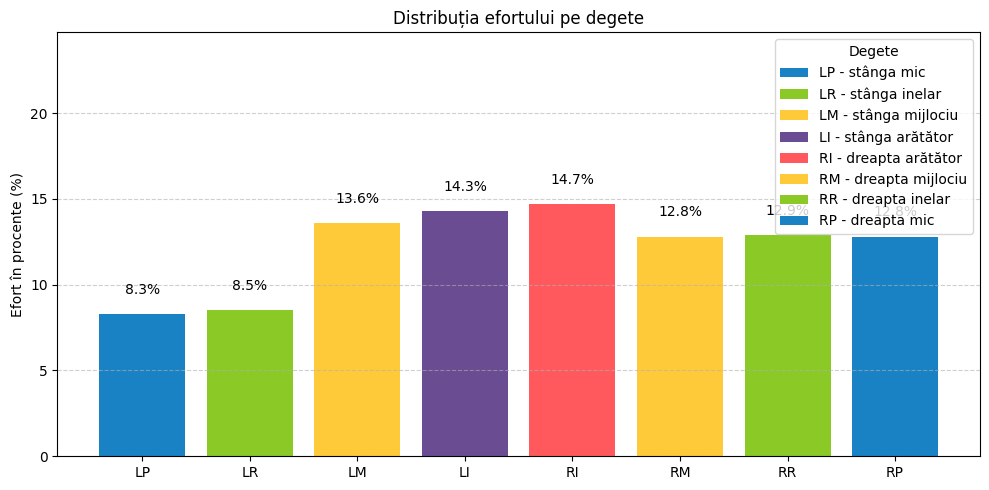

defaultdict(<class 'int'>, {'LP': 83, 'LR': 85, 'LM': 136, 'LI': 143, 'RI': 147, 'RM': 128, 'RR': 129, 'RP': 128})


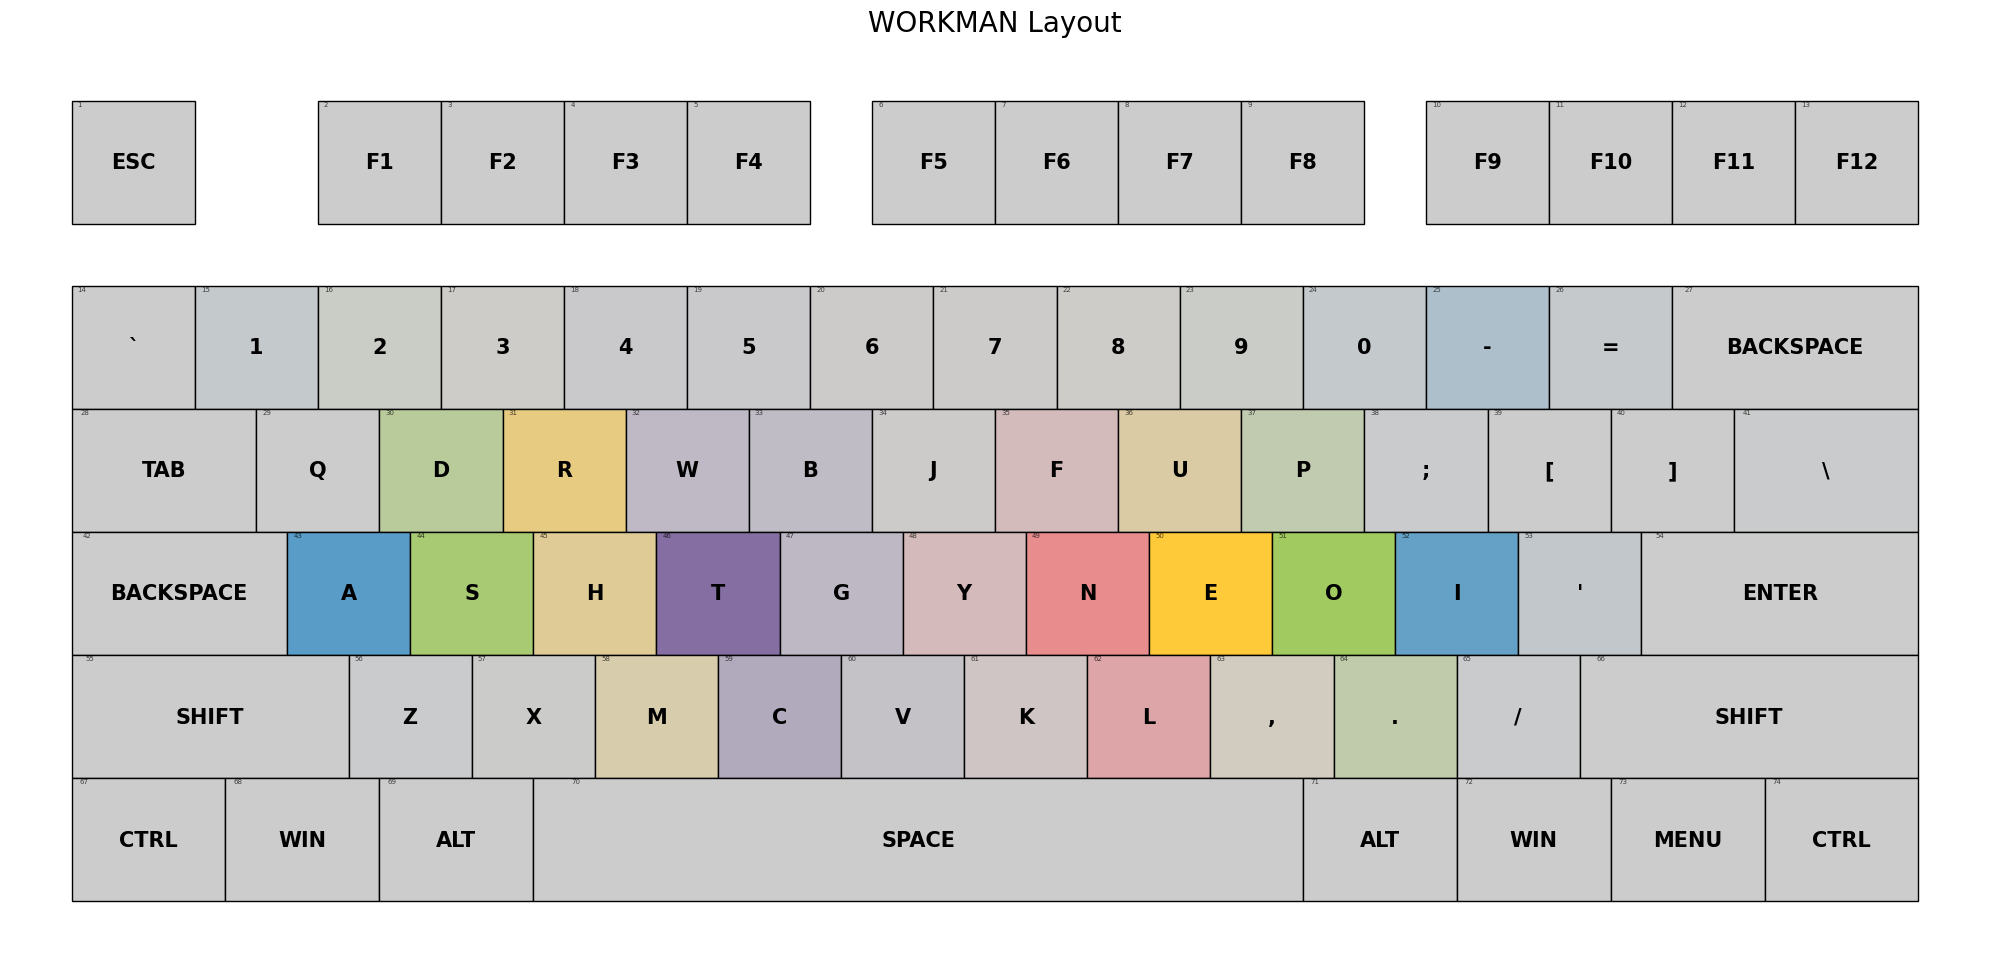

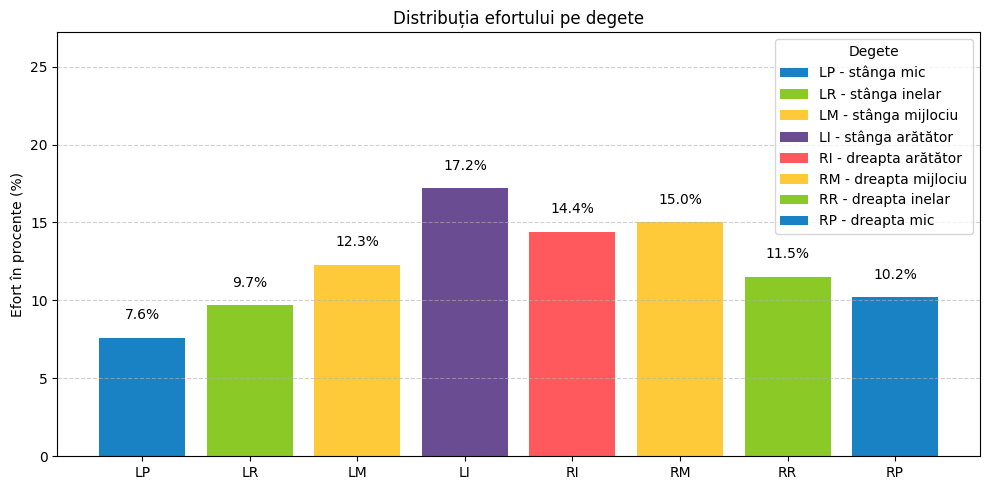

defaultdict(<class 'int'>, {'LP': 76, 'LR': 97, 'LM': 123, 'LI': 172, 'RI': 144, 'RM': 150, 'RR': 115, 'RP': 102})


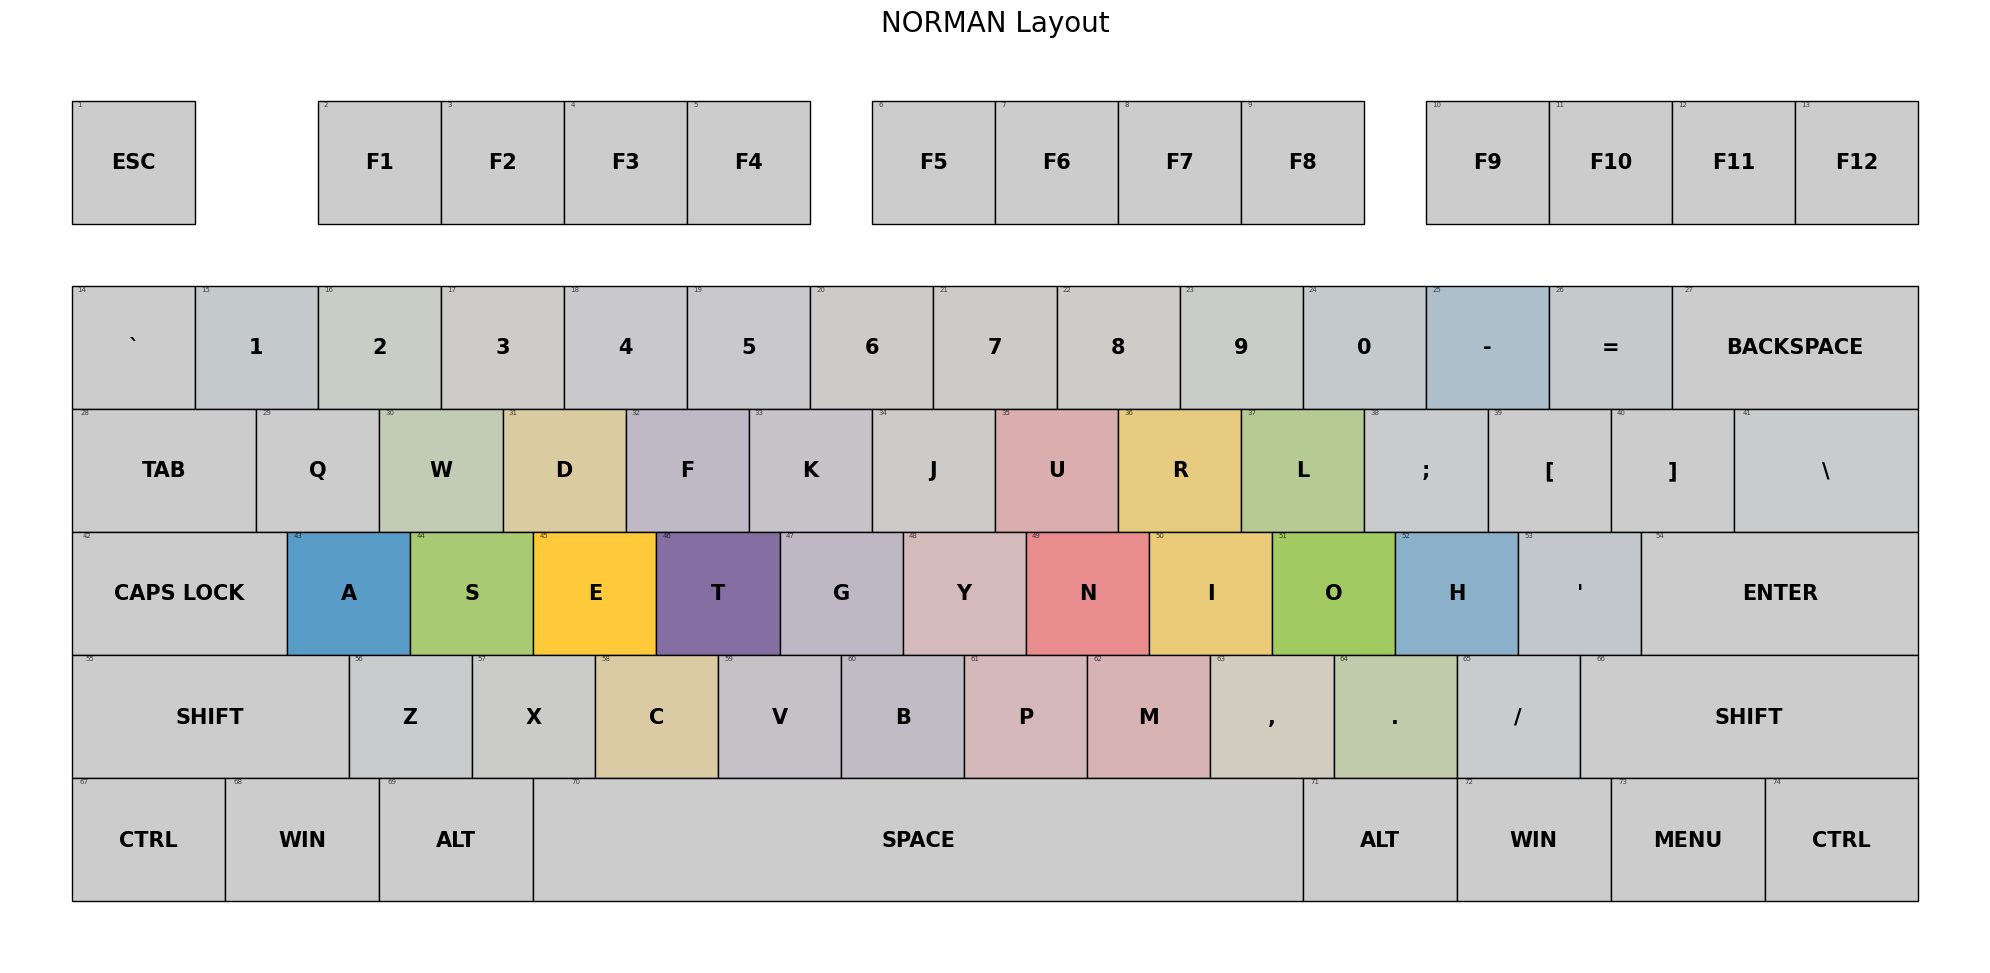

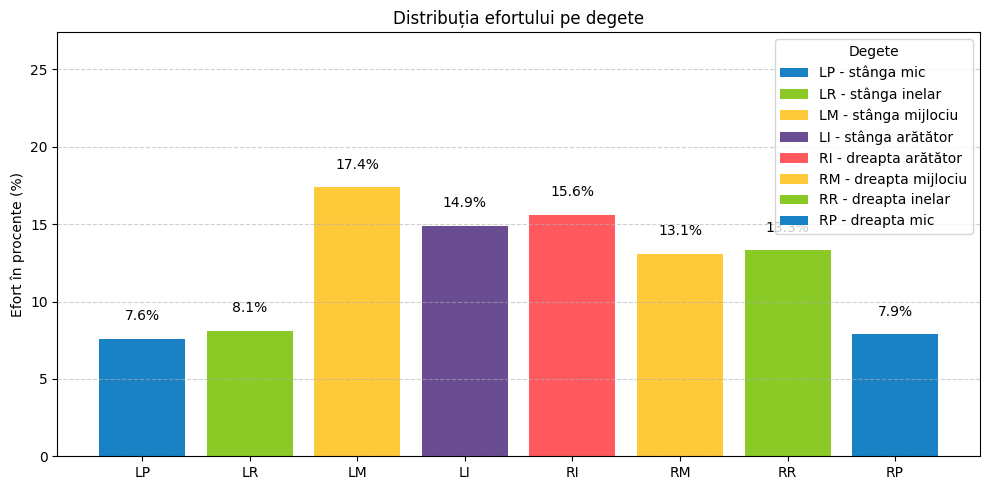

defaultdict(<class 'int'>, {'LP': 76, 'LR': 81, 'LM': 174, 'LI': 149, 'RI': 156, 'RM': 131, 'RR': 133, 'RP': 79})


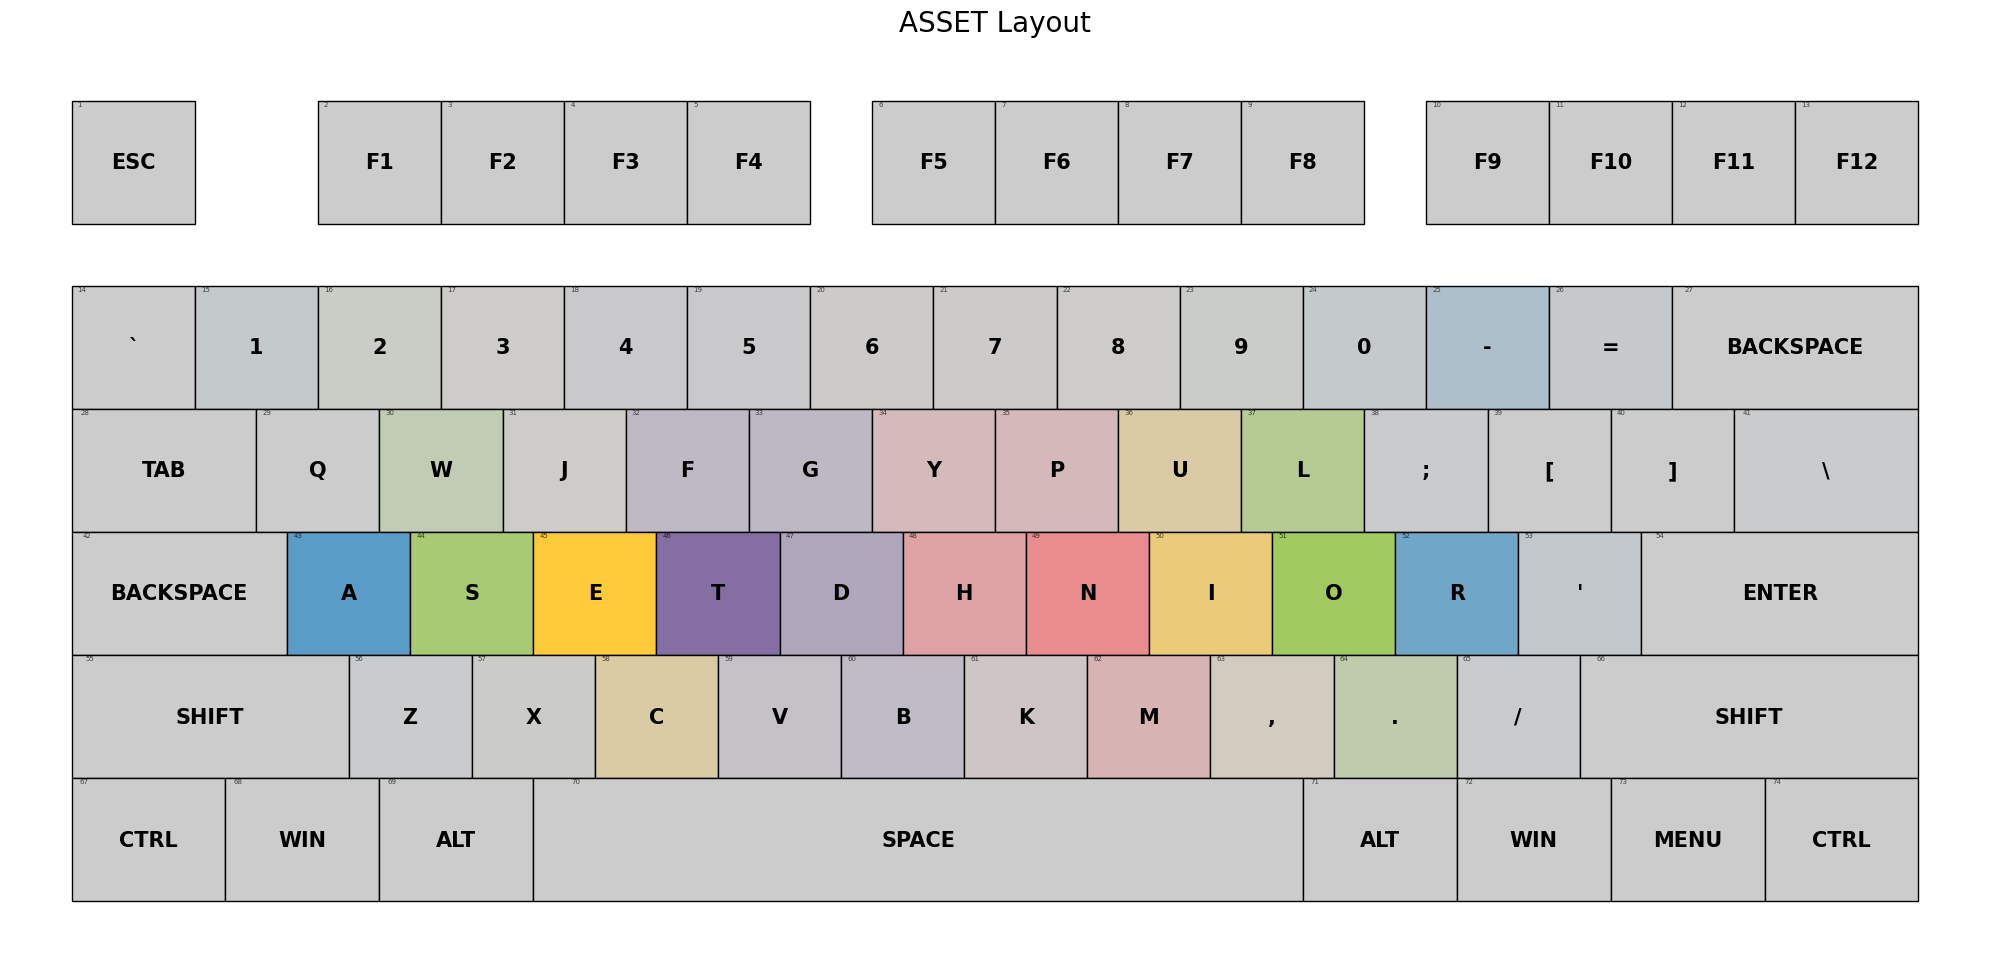

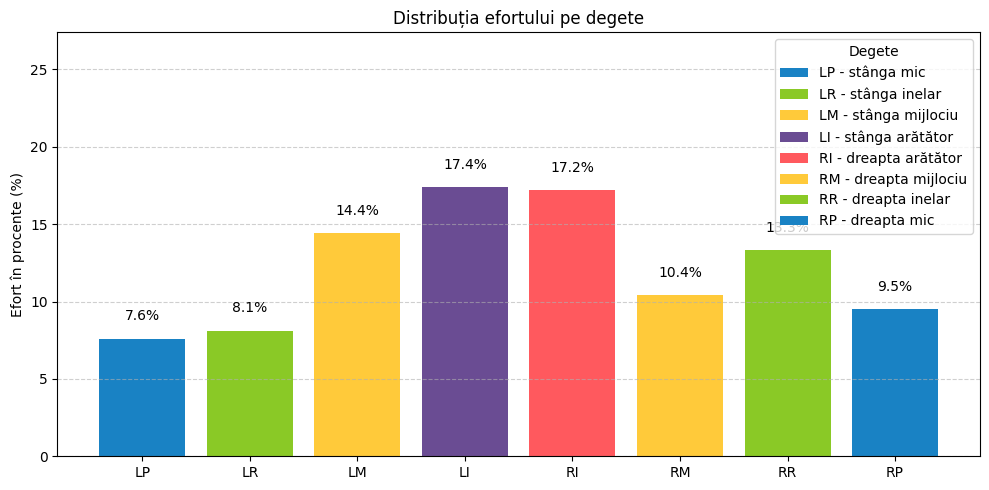

defaultdict(<class 'int'>, {'LP': 76, 'LR': 81, 'LM': 144, 'LI': 174, 'RI': 172, 'RM': 104, 'RR': 133, 'RP': 95})


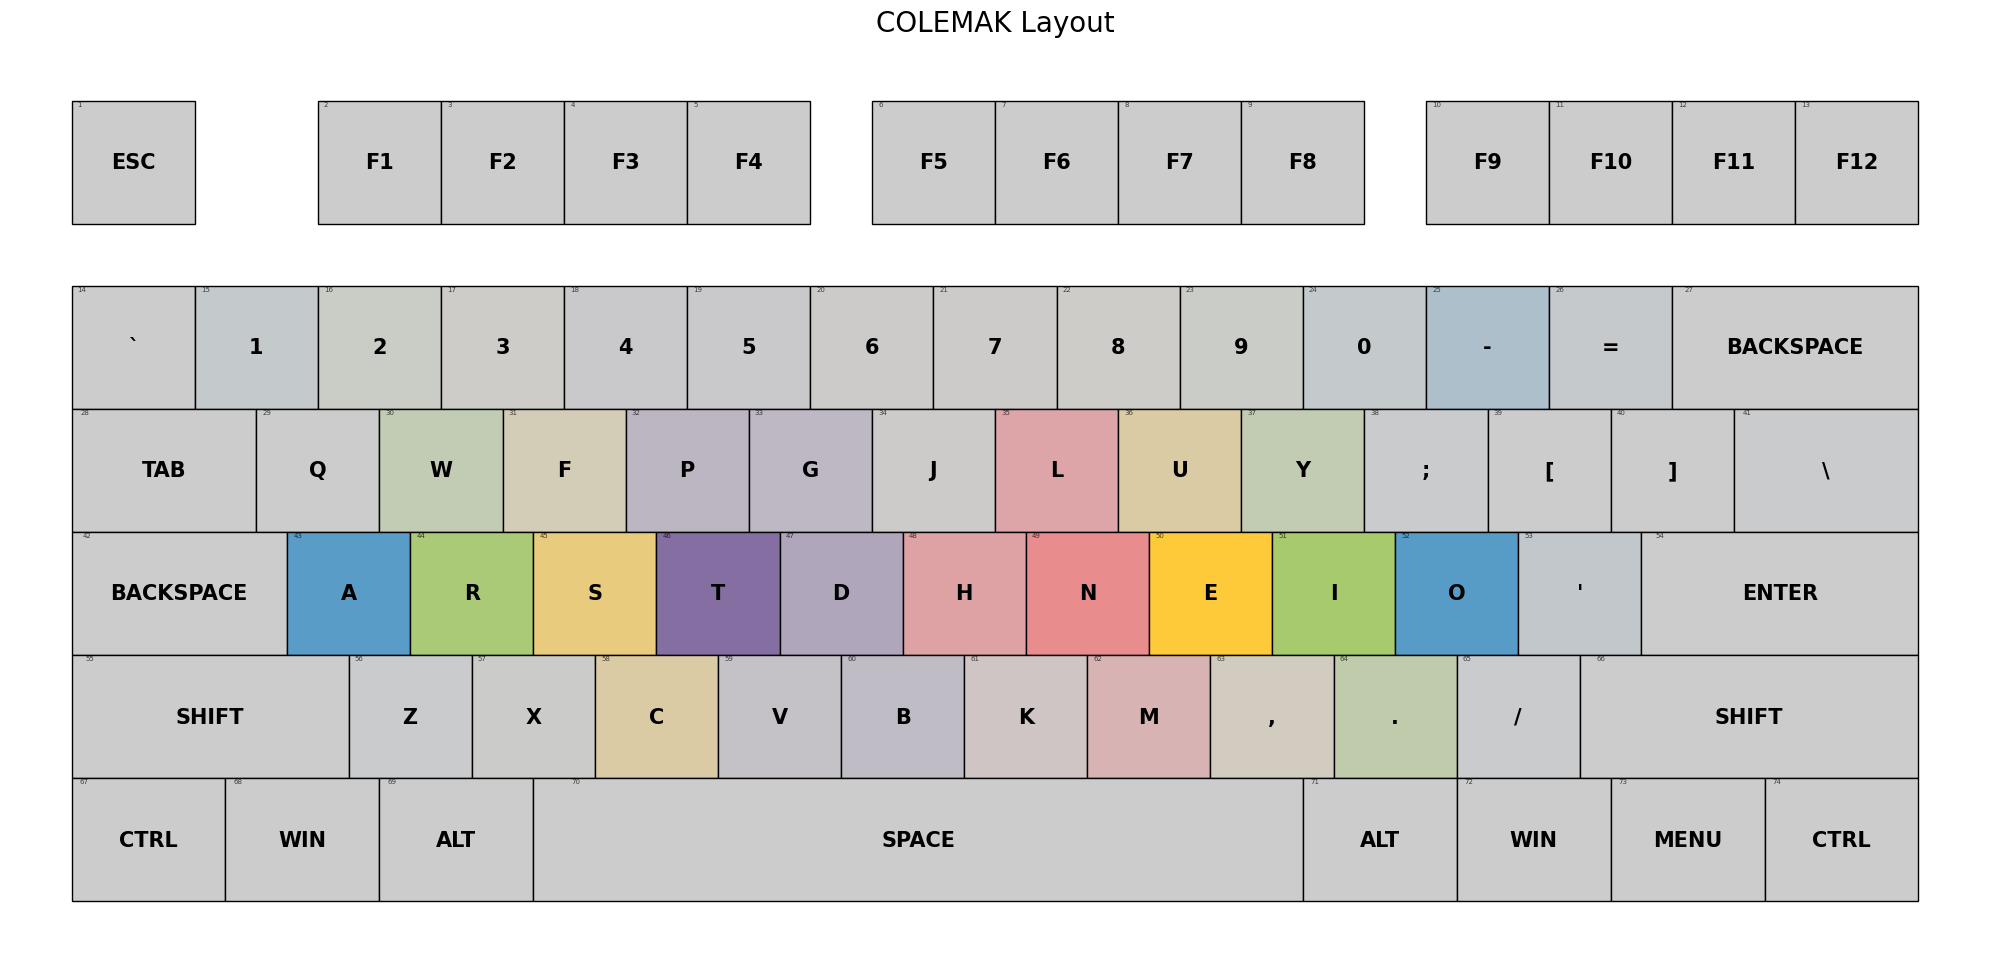

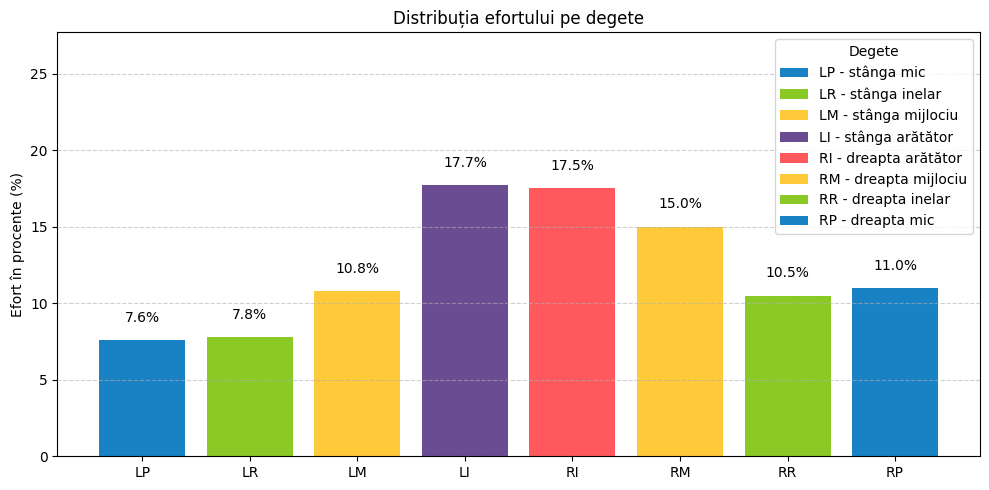

defaultdict(<class 'int'>, {'LP': 76, 'LR': 78, 'LM': 108, 'LI': 177, 'RI': 175, 'RM': 150, 'RR': 105, 'RP': 110})


In [ ]:
for layout in layouts_to_test:
    print(print_layout(layout, key_percentage))